## Initiation et importation des packages

In [4]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [71]:
# conda install -c anaconda py-xgboost ,sur le prompt anaconda

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
from sklearn.metrics import make_scorer,recall_score,roc_auc_score,plot_confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold,RepeatedStratifiedKFold,cross_val_score,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cluster import MeanShift
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks,ClusterCentroids,EditedNearestNeighbours,NeighbourhoodCleaningRule
from imblearn.datasets import make_imbalance
from imblearn.pipeline import Pipeline
from imblearn.combine  import SMOTETomek,SMOTEENN
from imblearn.ensemble import EasyEnsembleClassifier
from xgboost import XGBClassifier

## Importation des données

In [2]:
df = pd.read_csv('wisconsin.csv',sep=',')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,S
0,16,5,1,1,1,2,1,3,1,1,2
1,41,5,4,4,5,7,10,3,2,1,2
2,15,3,1,1,1,2,2,3,1,1,2
3,41,6,8,8,1,3,4,3,7,1,2
4,17,4,1,1,3,2,1,3,1,1,2


## Division Train/Test

Avant tout, nous divisons nos données en deux groupes : Train & Test. Ceci nous assure que les données de test ne seront pas touchées pendant notre "Training" des modèles et donc n'affectera pas les résultats(Métriques) de notre test.

Nous optons pour un split Train: 80% , Test: 20%

Certains datasets de classification n'ont pas un nombre équilibré d'exemples pour chaque label de classe. Il est donc souhaitable de diviser l'ensemble de données en ensembles de Test et Training de manière à conserver les mêmes proportions d'exemples dans chaque classe que celles observées dans le dataset original.
A cet effet, nous utiliserons un "Stratified Split"


In [3]:
dfVal = df.values
# Division en Features & Labels
X, y = dfVal[:, :-1], dfVal[:, -1]
print('Format Features:{} ; Format Labels:{}'.format(X.shape,y.shape))

Format Features:(663, 10) ; Format Labels:(663,)


In [4]:
#Division en Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(530, 10) (133, 10) (530,) (133,)


Il est à noter que ce qui precède est un exemple illustratif. Dans ce ce qui suit nous utiliserons une k-fold cross validation afin d'avoir une couverture plus complète/maximisée des données et les alterner entre training set et testing set et ainsi nous assurer que le modèle ne passe pas en Overfitting/Underfitting.

Pour un exemple de 5-fold cross validation:

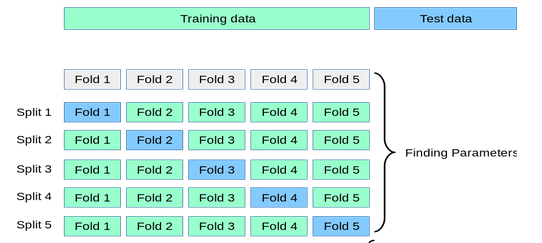

## 1. Imbalenced Data - Données déséquilibrées

On introduit un déséquilibre selon : Positif(4) : 10% , Négatif(2): 90%


In [5]:
def Equilibre(seq):

    n = len(seq)
    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    k = len(classes)

    H = -sum([ (count/n) * np.log((count/n)) for clas,count in classes]) #Entropie de Shannon
    return H/np.log(k)

In [6]:
print('Distribution avant déséquilibre: {}'.format(Counter(y)))

Distribution avant déséquilibre: Counter({2: 434, 4: 229})


In [8]:
print('Distribution avant déséquilibre(Entropie): {}'.format(Equilibre(y)))

Distribution avant déséquilibre(Entropie): 0.929892356711224


In [7]:
X_des, y_des = make_imbalance(X, y,sampling_strategy={2: 400, 4:20}, random_state=1)
X_train_des, X_test_des, y_train_des, y_test_des = train_test_split(X_des, y_des, test_size=0.2, random_state=1)


In [9]:
type(Counter(y))

collections.Counter

In [8]:
print('Distribution après déséquilibre: {}'.format(Counter(y_des)))

Distribution après déséquilibre: Counter({2: 400, 4: 20})


([<matplotlib.axis.XTick at 0x1ccd29832e0>,
 [Text(0, 0, 'Benign'), Text(0, 0, 'Malignant')])

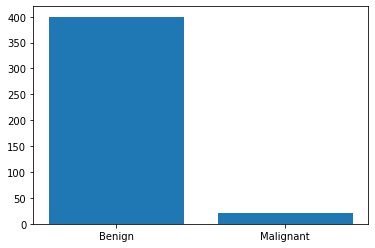

In [16]:
plt.bar(range(len(Counter(y_des))), list(Counter(y_des).values()), align='center')
plt.xticks(range(len(Counter(y_des))), ["Benign","Malignant"])

In [11]:
print('Distribution après déséquilibre(Entropie): {}'.format(Equilibre(y_des)))

Distribution après déséquilibre(Entropie): 0.2761954276479391


Les occurences du cas Négatif ne sont désormais plus représentatives. Nous pourrons le constater par ce qui suit.
A présent, nous adaptons un classificateur aux données. On choisit les RandomForests puisqu'il réduit l'overfitting et nous donnera donc une meilleure idée de l'Accuracy.

In [12]:
# On instancie l'objet cross-validation avec stratification et répétition
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# On instancie le modèle
modele = LogisticRegression()
cv_results = cross_validate(modele, X_des, y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                            cv=cv, n_jobs=-1,return_estimator=True,return_train_score=True)
# On récupère les scores au pluriel puisque nous validons sur plusieurs vagues et on moyenne sur ces différents scores
print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results['test_accuracy']),
                                                               np.mean(cv_results['train_accuracy']),
                                                               np.mean(cv_results['test_roc_auc'])))

Testing Accuracy: 0.9643 ; Training Accuracy: 0.9837 ; Roc_Auc: 0.7596 


Une matrice de confusion est un résumé des résultats des prédictions sur un problème de classification.

Le nombre de prédictions correctes et incorrectes est résumé avec des valeurs de comptage et ventilé par classe.

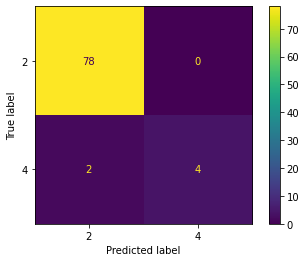

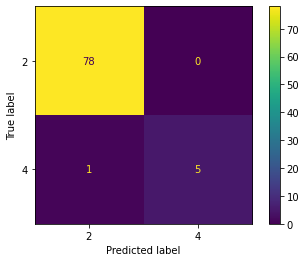

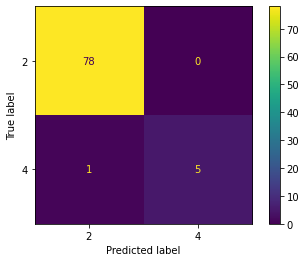

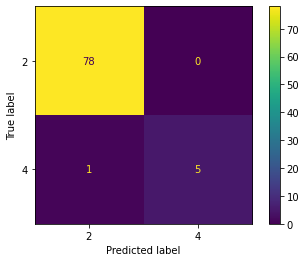

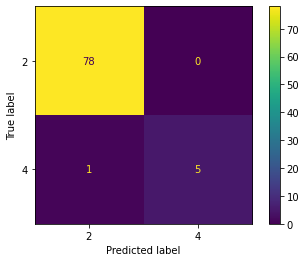

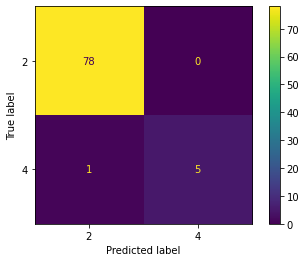

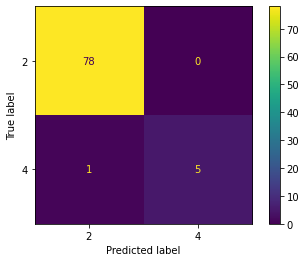

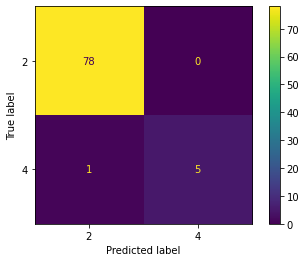

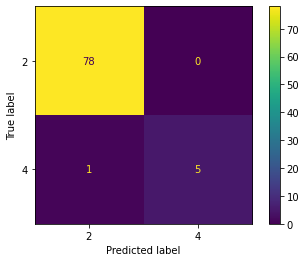

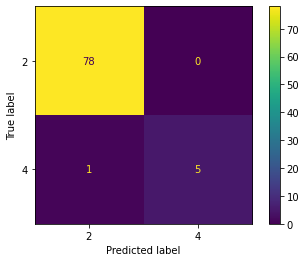

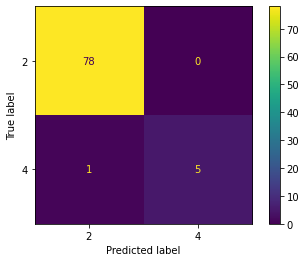

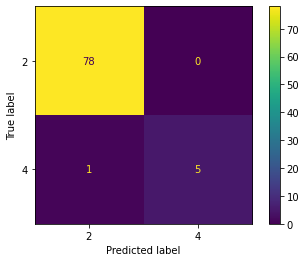

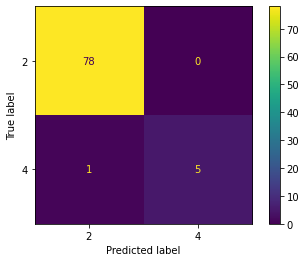

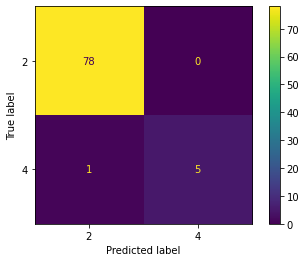

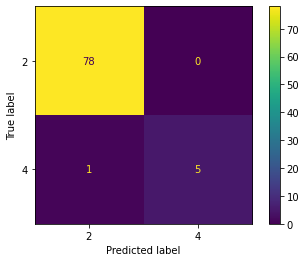

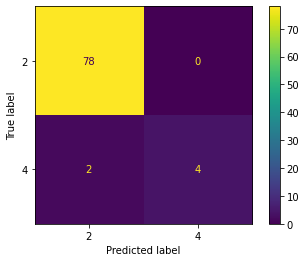

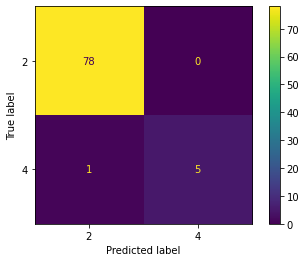

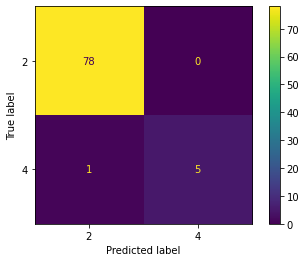

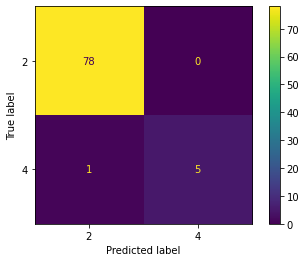

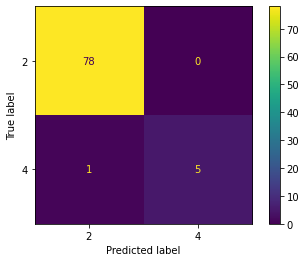

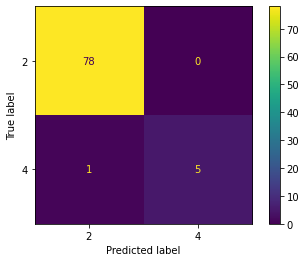

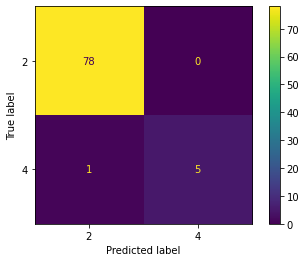

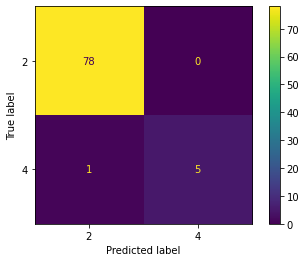

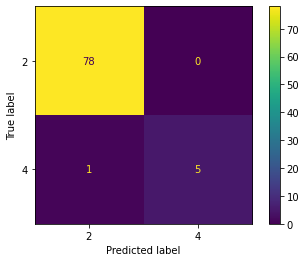

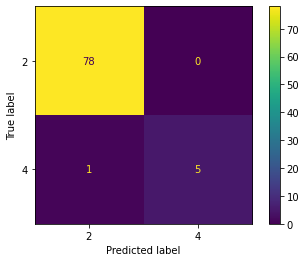

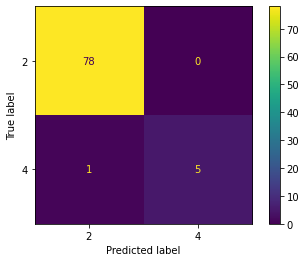

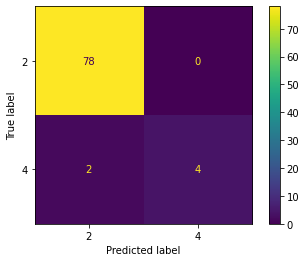

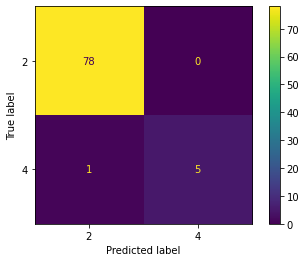

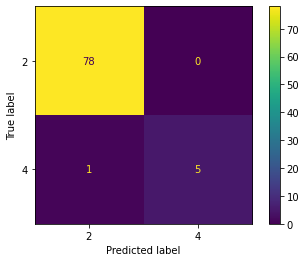

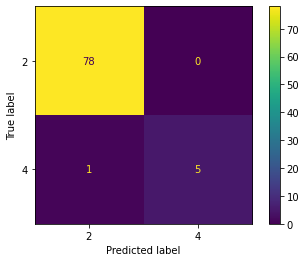

In [13]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_results['estimator']:
    plot_confusion_matrix(estimator, X_test_des, y_test_des)
 


On voit que l'algorithme prédit presque intégralement des cas Négatifs. Cependant comme les ensembles "held-out" pour le test sur chaque fold ne contiennent que des auntintés minoritaires de cas "en vérité" Positifs. L'algorithme ne fait pas trop d'erreurs puisqu'il n'est pas amené à prédire des cas de minorité. C'ets un cas d'Overfitting
~~ A rajouter qu'on a testé sur les ensembles de test puisque la cross-validation ne retourne que les estimateurs utilisés sur chaque fold.

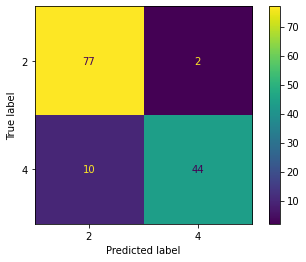

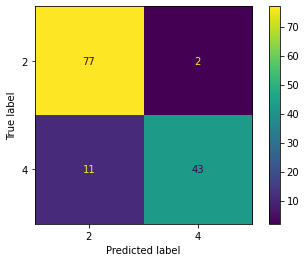

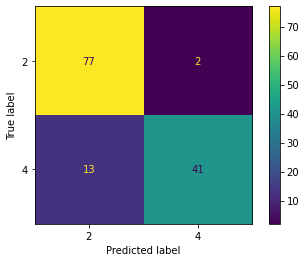

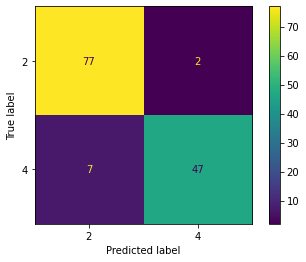

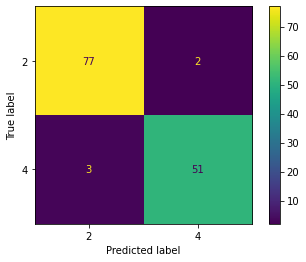

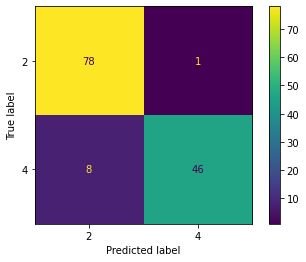

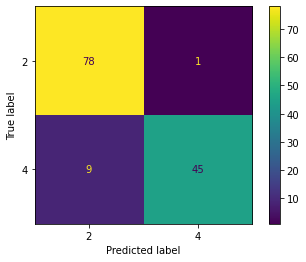

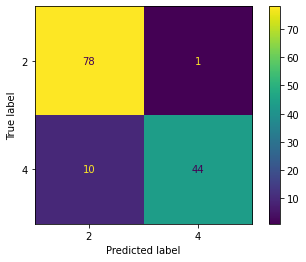

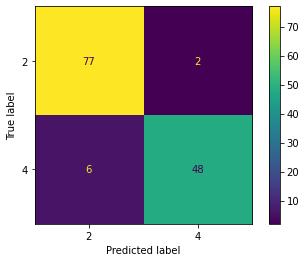

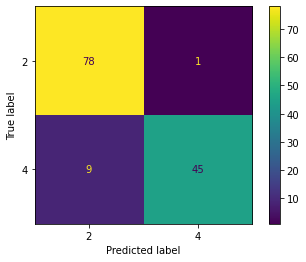

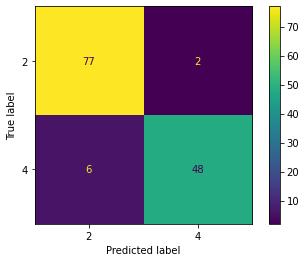

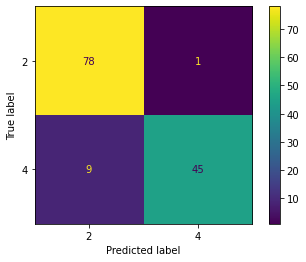

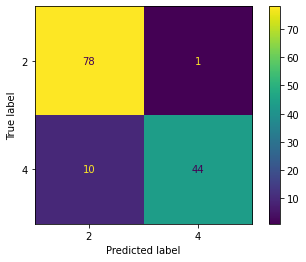

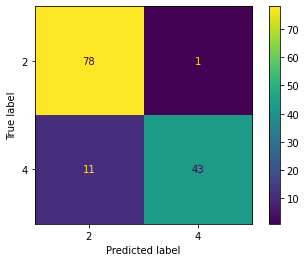

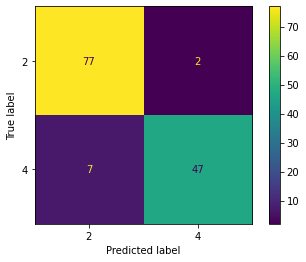

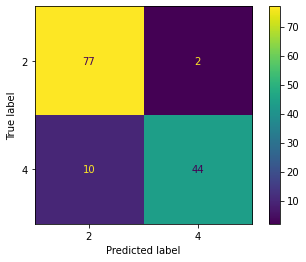

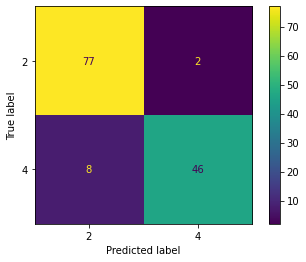

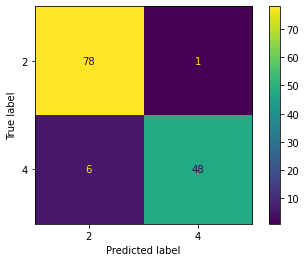

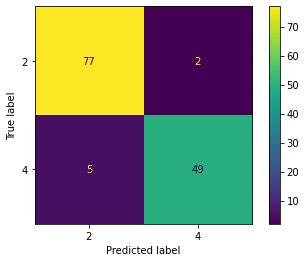

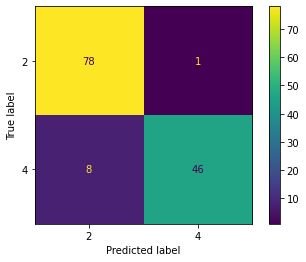

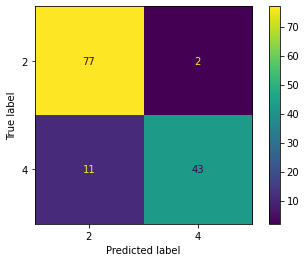

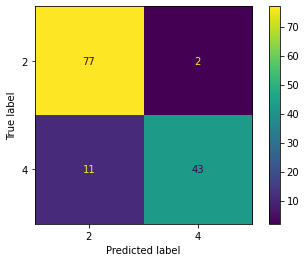

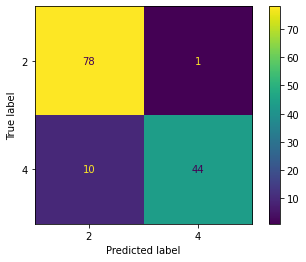

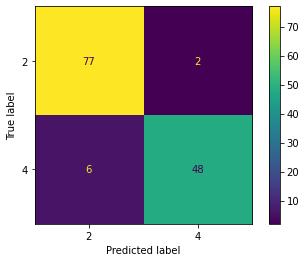

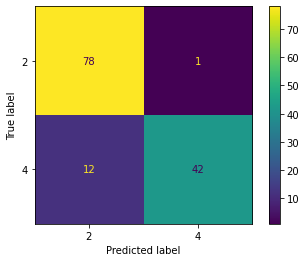

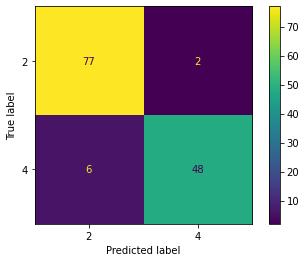

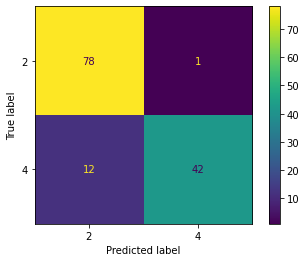

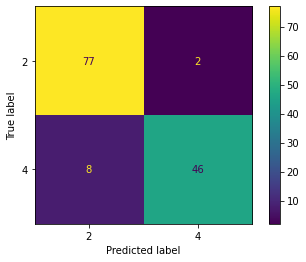

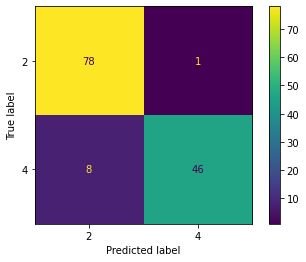

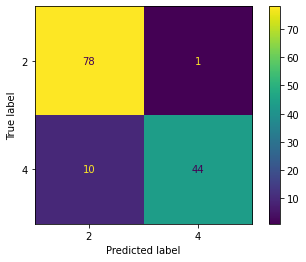

In [14]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_results['estimator']:
    plot_confusion_matrix(estimator, X_test, y_test)

### 1.1. Correction - Oversampling

#### 1.1.1. Random Oversampling

 Le Random Oversampling est un processus qui consiste à dupliquer aléatoirement les observations de la classe minoritaire afin de renforcer son signal.

In [15]:
# On instancie l'objet 
over_sampler = RandomOverSampler()

# On adapte l'objet aux données
x_oversamp, y_oversamp = over_sampler.fit_sample(X_des, y_des)

print('Distribution après RandomOversampling(Entropie): {}'.format(Equilibre(y_oversamp)))

Distribution après RandomOversampling(Entropie): 1.0


In [16]:
etapes = [('oversampler', RandomOverSampler(sampling_strategy='minority')), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_results_rand_samp = cross_validate(pipeline,X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_rand_samp['test_accuracy']),
                                                               np.mean(cv_results_rand_samp['train_accuracy']),
                                                               np.mean(cv_results_rand_samp['test_roc_auc'])))

Test Accuracy: 0.9524 ; Training Accuracy : 0.9690 ; Roc_Auc: 0.8562 


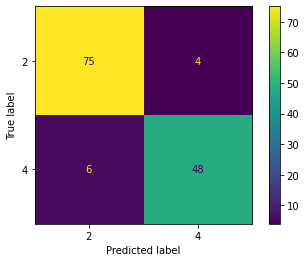

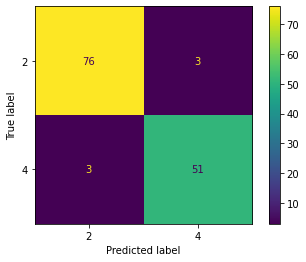

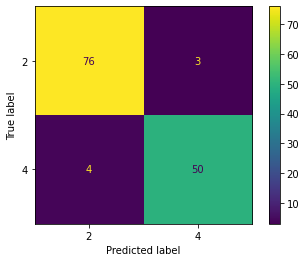

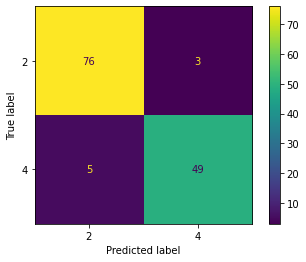

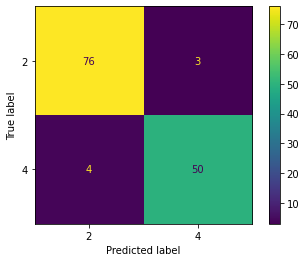

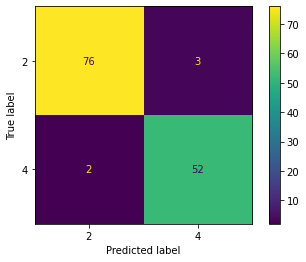

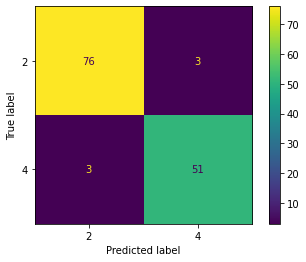

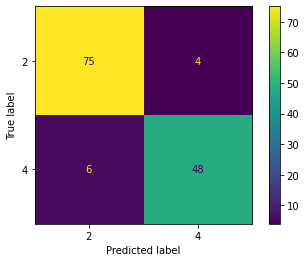

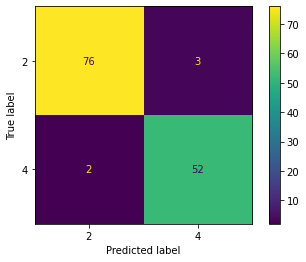

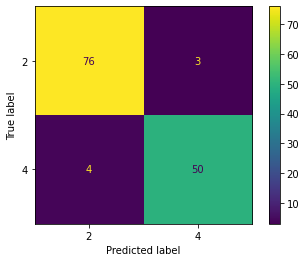

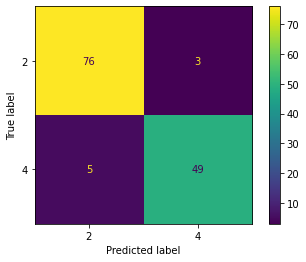

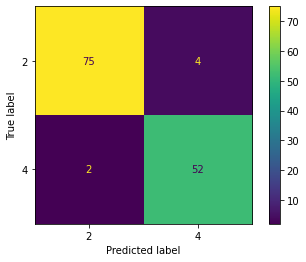

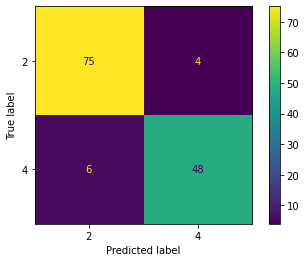

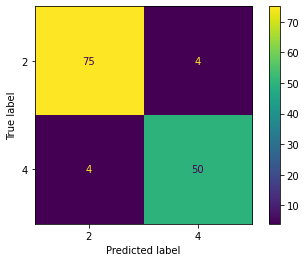

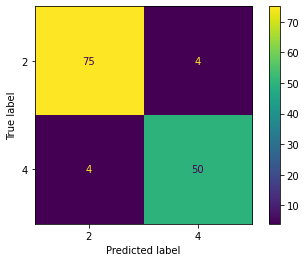

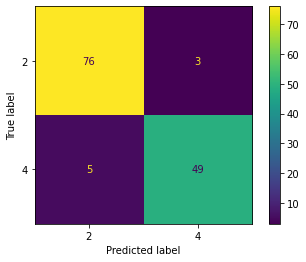

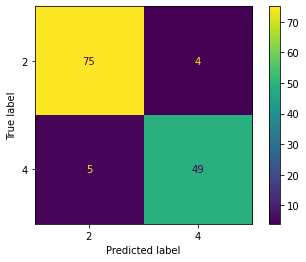

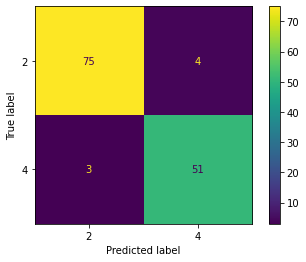

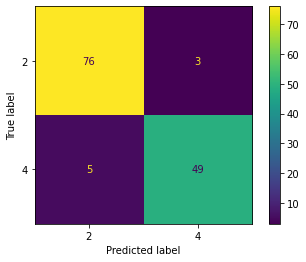

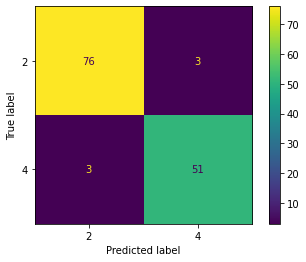

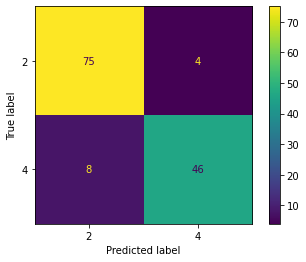

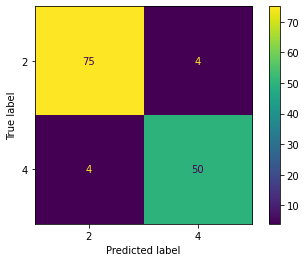

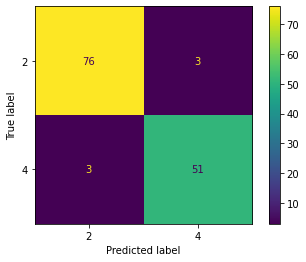

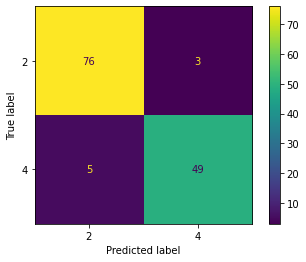

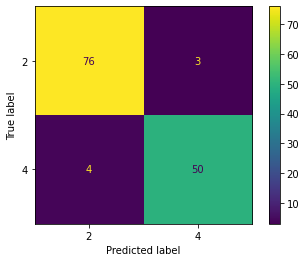

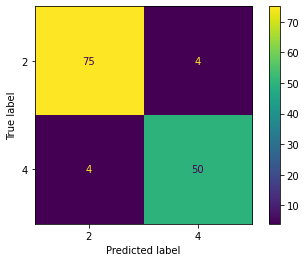

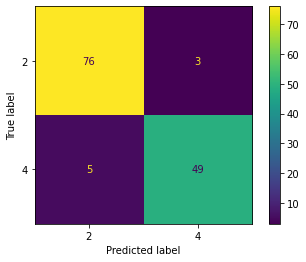

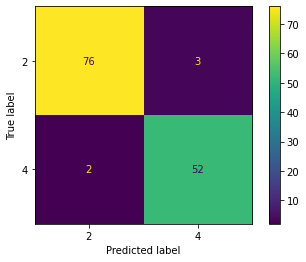

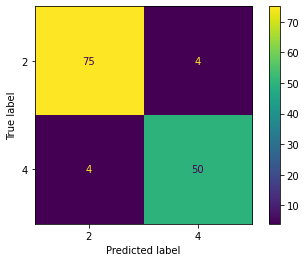

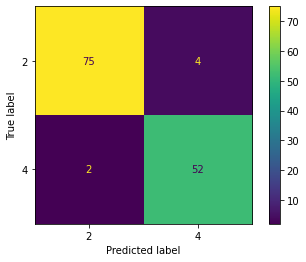

In [17]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_results_rand_samp['estimator']:
    plot_confusion_matrix(estimator, X_test, y_test)

#### 1.1.2. SMOTE Oversampling

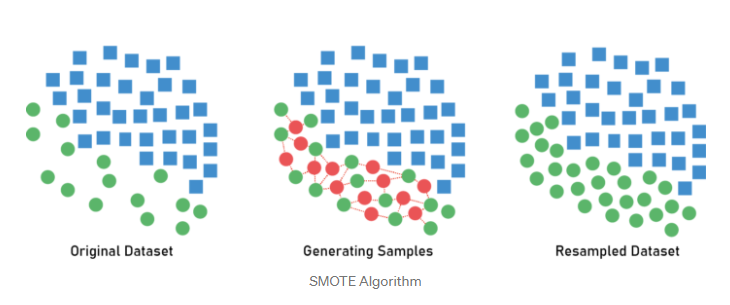

In [18]:
# On instancie l'objet 
smote_sampler = SMOTE()

# On adapte l'objet aux données
x_smote, y_smote =smote_sampler.fit_sample(X_des, y_des)

print('Distribution après RandomOversampling(Entropie): {}'.format(Equilibre(y_smote)))

Distribution après RandomOversampling(Entropie): 1.0


In [19]:
#On change le sampler dans notre pipeline en un sampler SMOTE
etapes = [('smotesampler', SMOTE(sampling_strategy='minority')), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_results_smote = cross_validate(pipeline,X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True,return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_smote['test_accuracy']),
                                                               np.mean(cv_results_smote['train_accuracy']),
                                                               np.mean(cv_results_smote['test_roc_auc'])))

Test Accuracy: 0.9651 ; Training Accuracy : 0.9802 ; Roc_Auc: 0.7996 


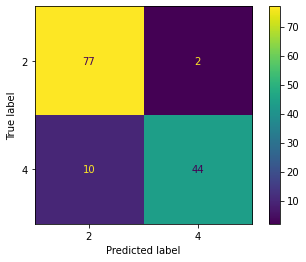

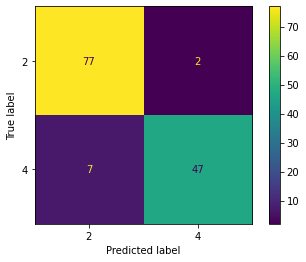

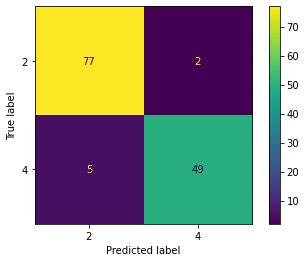

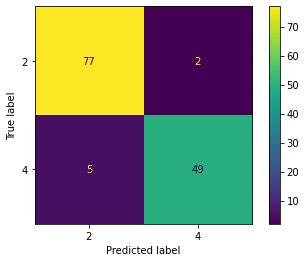

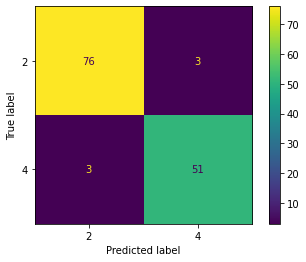

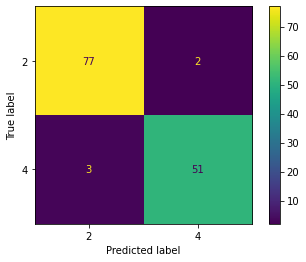

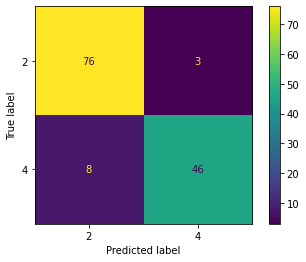

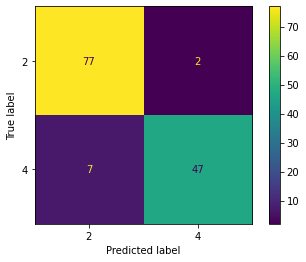

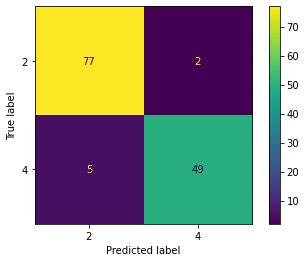

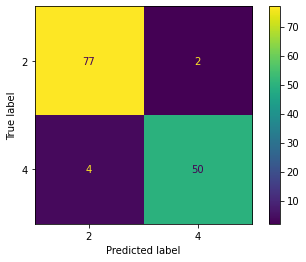

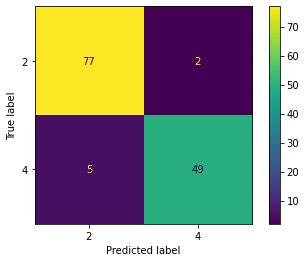

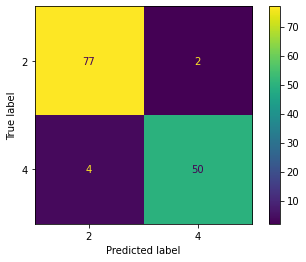

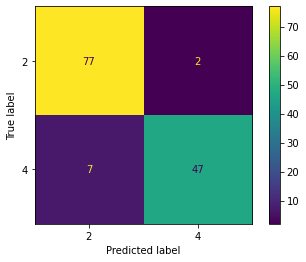

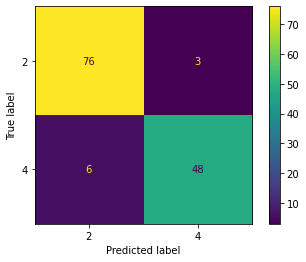

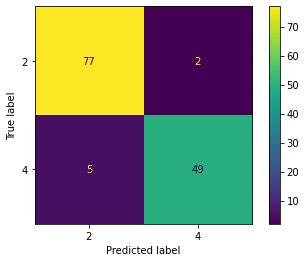

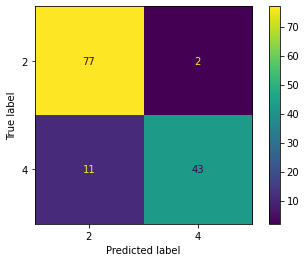

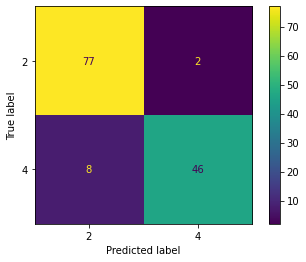

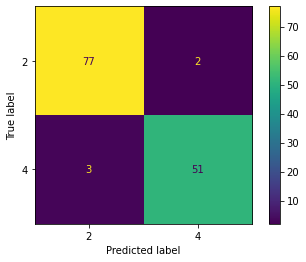

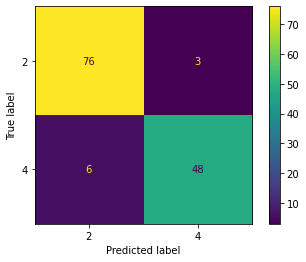

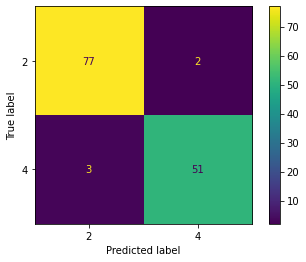

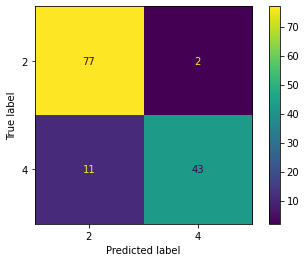

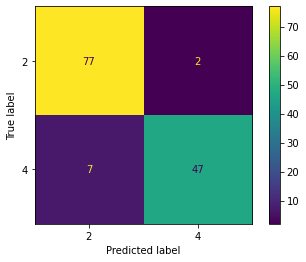

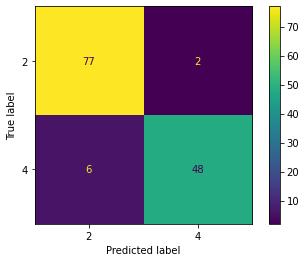

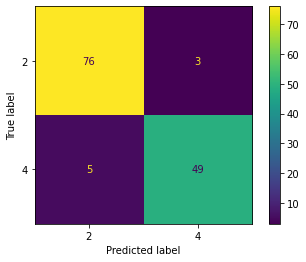

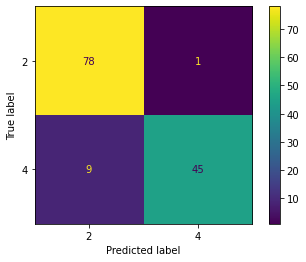

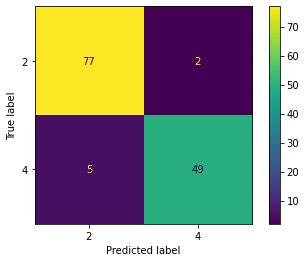

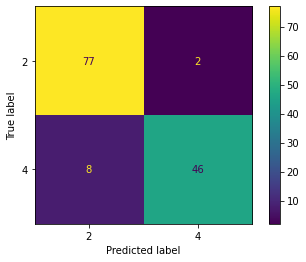

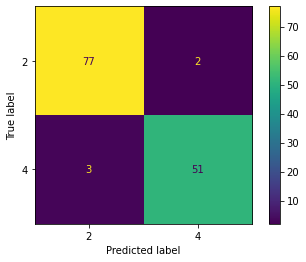

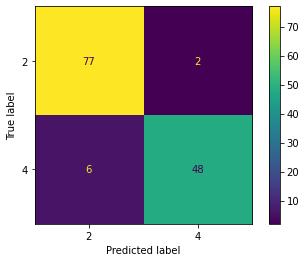

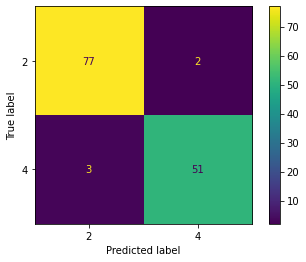

In [20]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_results_smote['estimator']:
    plot_confusion_matrix(estimator, X_test, y_test)

#### 1.1.3. ADASYN Oversampling

In [21]:
# On instancie l'objet 
adasyn_sampler = ADASYN()

# On adapte l'objet aux données
x_adasyn, y_adasyn=adasyn_sampler.fit_sample(X_des, y_des)

print('Distribution après ADASYNsampling(Entropie): {}'.format(Equilibre(y_adasyn)))

Distribution après ADASYNsampling(Entropie): 0.9999988700711486


In [22]:
#On change le sampler dans notre pipeline en un sampler ADASYN
etapes = [('adasynsampler', ADASYN(sampling_strategy='minority')), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_results_adasyn = cross_validate(pipeline,X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_adasyn['test_accuracy']),
                                                               np.mean(cv_results_adasyn['train_accuracy']),
                                                               np.mean(cv_results_adasyn['test_roc_auc'])))

Test Accuracy: 0.9635 ; Training Accuracy : 0.9795 ; Roc_Auc: 0.7988 


#### 1.1.4. KMeansSMOTE,BorderlineSMOTE,SVMSMOTE

A ajouter si j'ai le temps.

#### 1.1.4. Synthèse  Oversampling

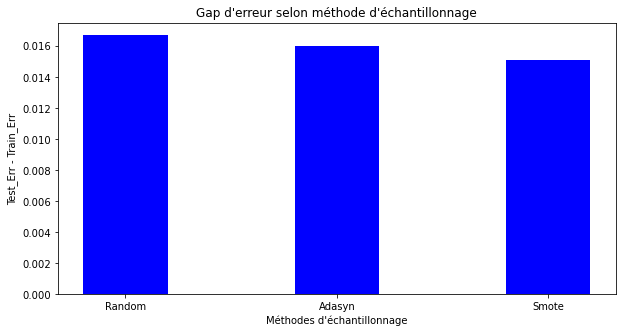

In [23]:
# On définit un dictionnaire avec pour éléments les différences d'erreurs:
#On simplifie les 1
err_diffs={'Random': np.mean(cv_results_rand_samp['train_accuracy'])-np.mean(cv_results_rand_samp['test_accuracy']),
           'Adasyn': np.mean(cv_results_adasyn['train_accuracy'])-np.mean(cv_results_adasyn['test_accuracy']),
           'Smote': np.mean(cv_results_smote['train_accuracy'])-np.mean(cv_results_smote['test_accuracy'])
           }

fig = plt.figure(figsize = (10, 5));

plt.bar(err_diffs.keys(), err_diffs.values(), color ='blue',width = 0.4)
  
plt.xlabel("Méthodes d'échantillonnage") 
plt.ylabel("Test_Err - Train_Err") 
plt.title("Gap d'erreur selon méthode d'échantillonnage") 
plt.show() 

On sait que le gap d'erreur est indicatif d'overfitting. Donc plus le gap est grand plus l'overfitting est important et donc plus la méthode nous donne un faux sens de bonne performance. Ce gap est en fait un résultat d'une grande variance.
Et donc selon le principe de "Bias-Variance Tradeoff" on a un plus petite "bias" et donc moins d'hypothèses sur la forme de la fonction cible du classificateur.
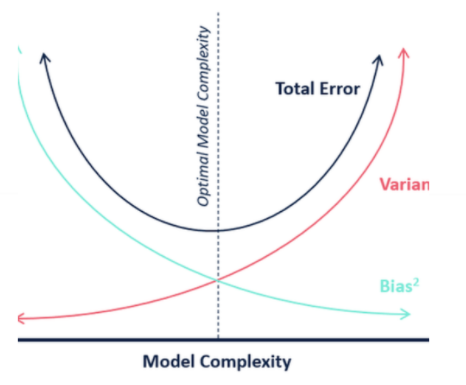

###### On déduit donc que : SMOTE > ADASYN > RandomOverSampling 

### 1.2. Correction - Undersampling

In [24]:
X_des_2, y_des_2 = make_imbalance(X, y,sampling_strategy={2: 430, 4:50}, random_state=1)

In [25]:
print('Distribution après déséquilibre: {}'.format(Counter(y_des_2)))

Distribution après déséquilibre: Counter({2: 430, 4: 50})


In [26]:
# Cette mesure est de grande utilité pour le tuning d'un bon déséquilibre pour mes besoins
print('Distribution après déséquilibre(Entropie): {}'.format(Equilibre(y_des_2)))

Distribution après déséquilibre(Entropie): 0.48206614808309317


On arrive sur un déséquilibre sub-50% , mais on change d'un nombre de cas minoritaires très petit comme benchmark et donc on aura un nombre d'instances non significatif post undersampling . On gardera en tête que les résultats ne seront pas aussi marqués qu'avant.

In [27]:
# On instancie l'objet cross-validation avec stratification et répétition
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# On instancie le modèle
modele = LogisticRegression()
cv_results_2 = cross_validate(modele, X_des_2, y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                            cv=cv, n_jobs=-1,return_estimator=True,return_train_score=True)
# On récupère les scores au pluriel puisque nous validons sur plusieurs vagues et on moyenne sur ces différents scores
print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_2['test_accuracy']),
                                                               np.mean(cv_results_2['train_accuracy']),
                                                               np.mean(cv_results_2['test_roc_auc'])))

Testing Accuracy: 0.9701 ; Training Accuracy: 0.9812 ; Roc_Auc: 0.9215 


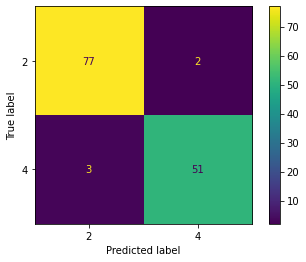

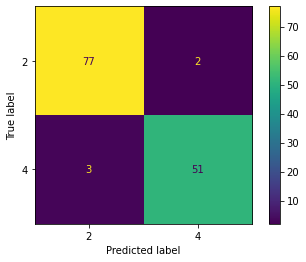

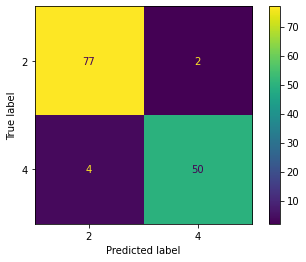

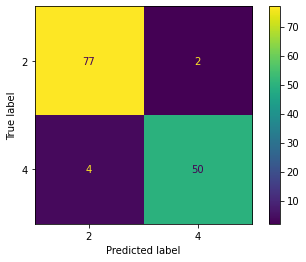

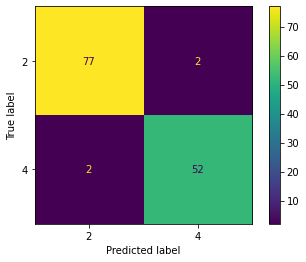

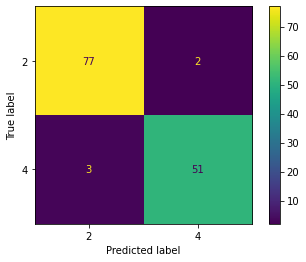

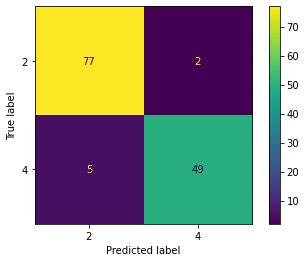

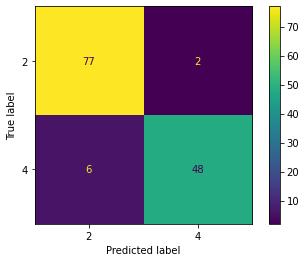

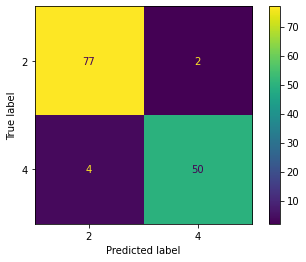

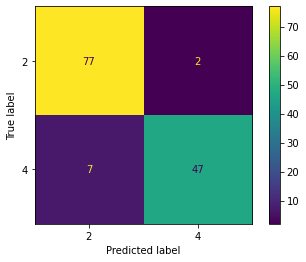

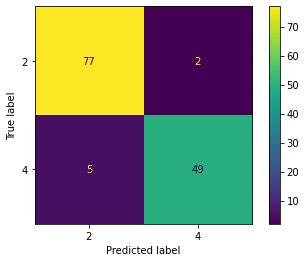

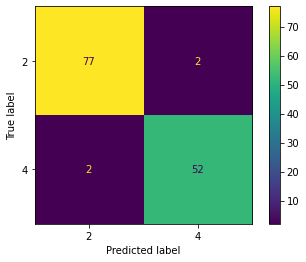

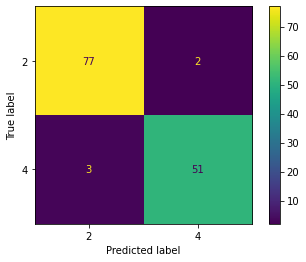

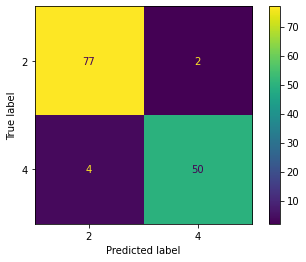

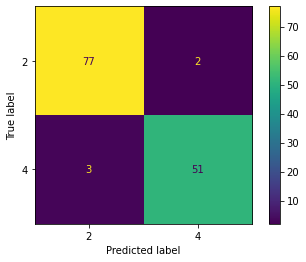

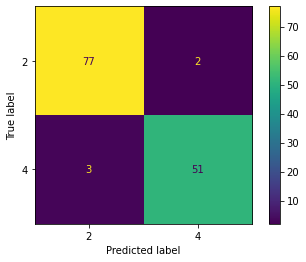

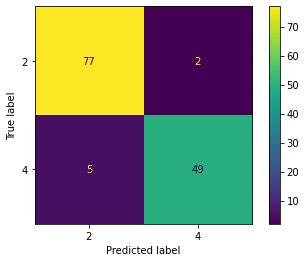

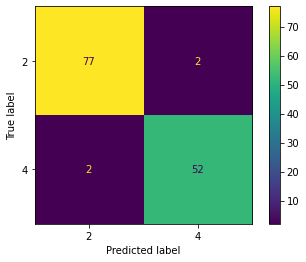

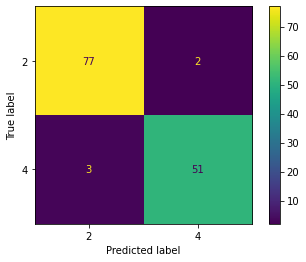

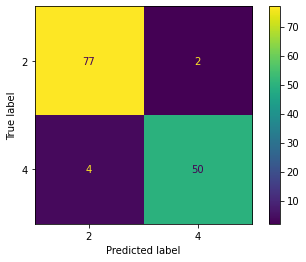

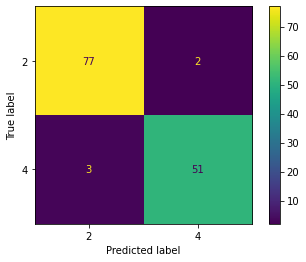

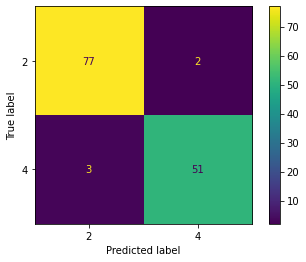

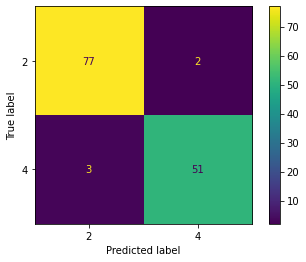

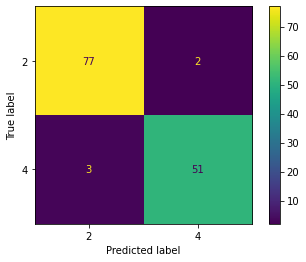

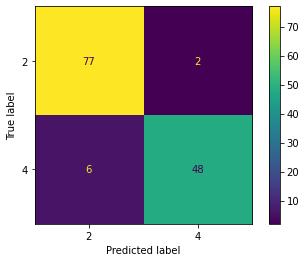

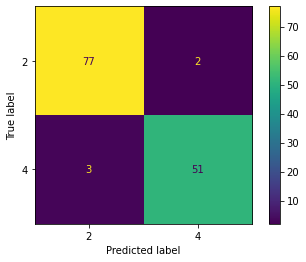

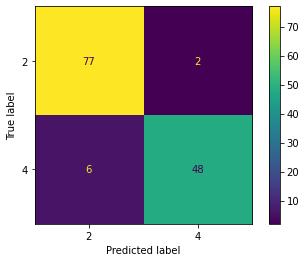

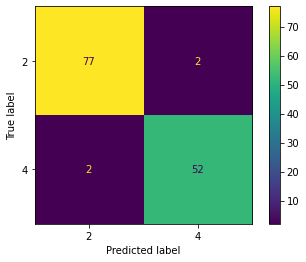

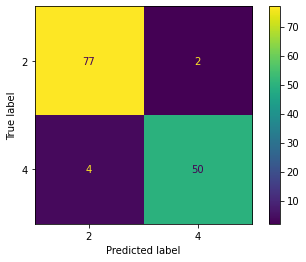

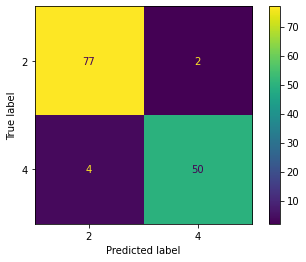

In [28]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_results_2['estimator']:
    plot_confusion_matrix(estimator, X_test, y_test)

Résultats similaires au premier déséquilibre. On procède.

#### 1.2.1. Random Undersampling

Le Random Undersampling supprime de façon aléatoire les données de la classe majoritaire afin d'atteindre un équilibre entre les deux classes

In [29]:
# On instancie l'objet 
rand_under_sampler = RandomUnderSampler(sampling_strategy='majority')

# On adapte l'objet aux données
x_rand_under, y_rand_under = rand_under_sampler.fit_sample(X_des_2, y_des_2)

print('Distribution après RandomOversampling(Entropie): {}'.format(Equilibre(y_rand_under)))

Distribution après RandomOversampling(Entropie): 1.0


On teste l'effet de la méthode sur la performance du classificateur

In [30]:
etapes = [('undersampler', RandomUnderSampler(sampling_strategy='majority')), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_results_rand_under_samp = cross_validate(pipeline,X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_rand_under_samp['test_accuracy']),
                                                               np.mean(cv_results_rand_under_samp['train_accuracy']),
                                                               np.mean(cv_results_rand_under_samp['test_roc_auc'])))

Test Accuracy: 0.9590 ; Training Accuracy : 0.9661 ; Roc_Auc: 0.9624 


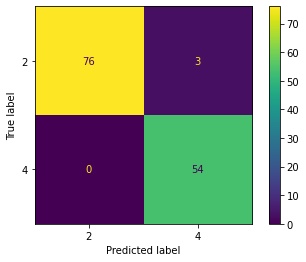

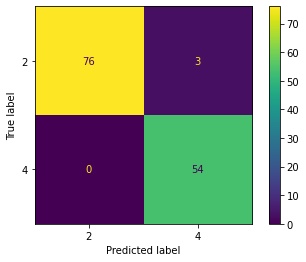

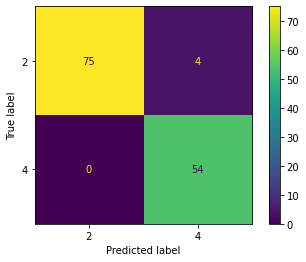

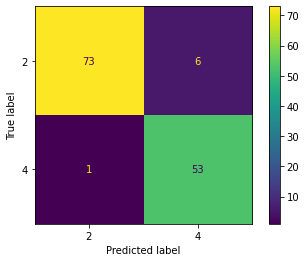

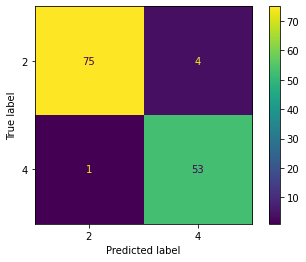

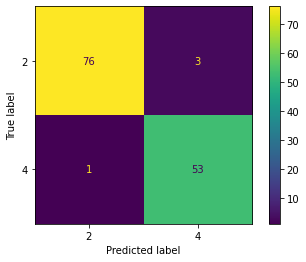

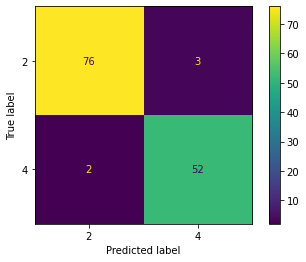

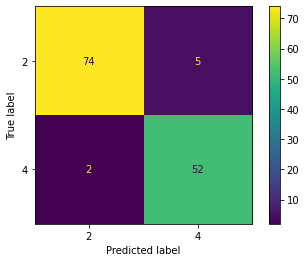

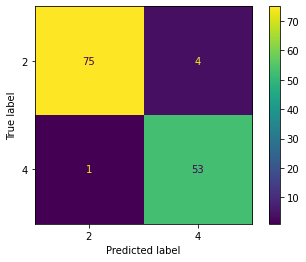

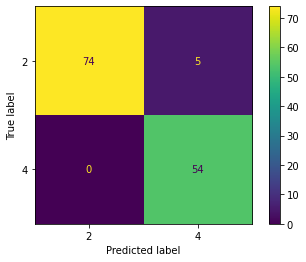

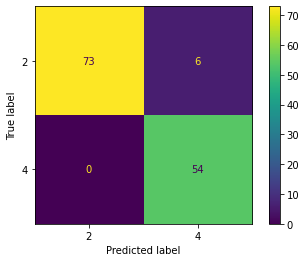

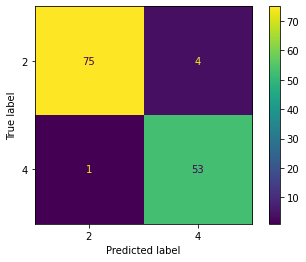

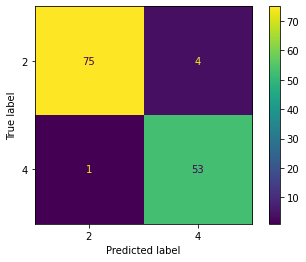

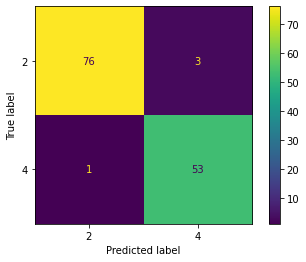

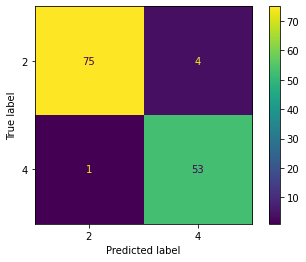

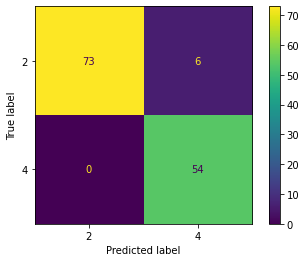

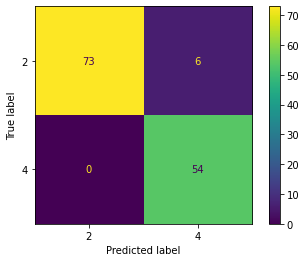

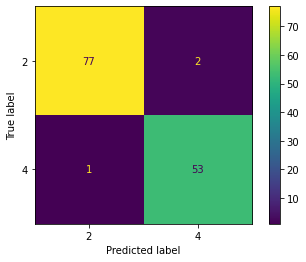

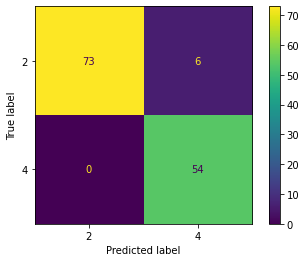

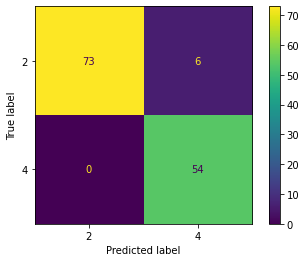

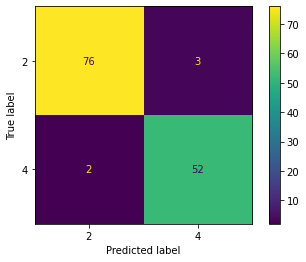

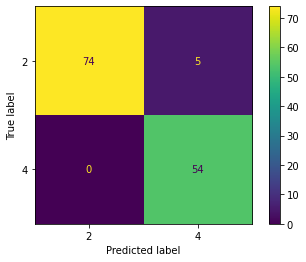

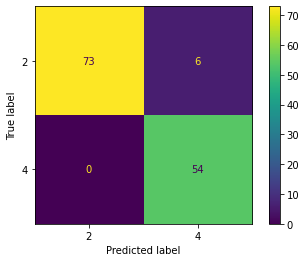

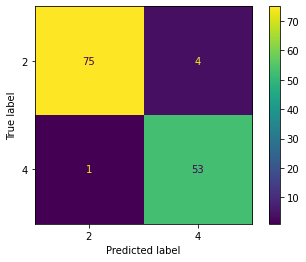

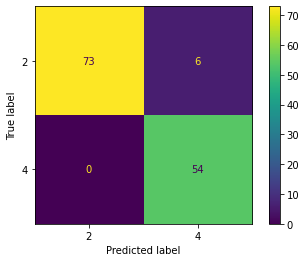

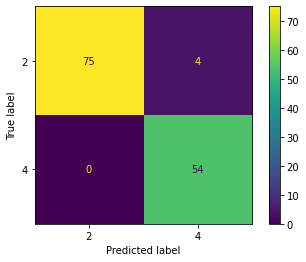

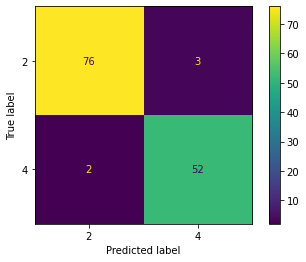

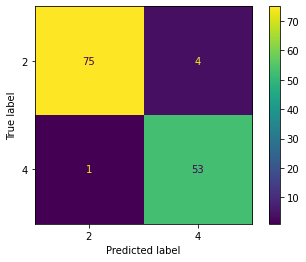

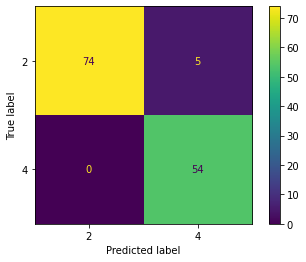

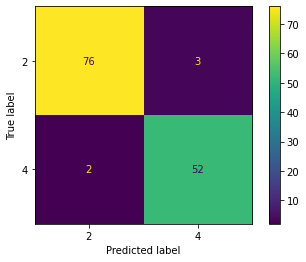

In [31]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_results_rand_under_samp['estimator']:
    plot_confusion_matrix(estimator, X_test, y_test)

La performance(Score Roc_Auc : 0.7596  -> 0.9588 )

#### 1.2.2. NearMiss Undersampling

L'algorithme NearMiss a été proposé pour résoudre le problème de la perte potentielle d'informations. Il est basé sur l'algorithme du nearest neighbor et comporte de nombreuses variations.

Les bases des algorithmes NearMiss sont les suivantes :<br>
   > 1.La méthode commence par calculer les distances entre toutes les instances de la classe majoritaire et les instances de la classe minoritaire.<br>
   >2.Ensuite, k instances de la classe majoritaire qui présentent les plus petites distances par rapport à celles de la classe minoritaire sont sélectionnées pour être retenues.<br>
   >3.Si il y a n instances de la classe minoritaire, la méthode NearMiss donnera k × n instances de la classe majoritaire.<br>


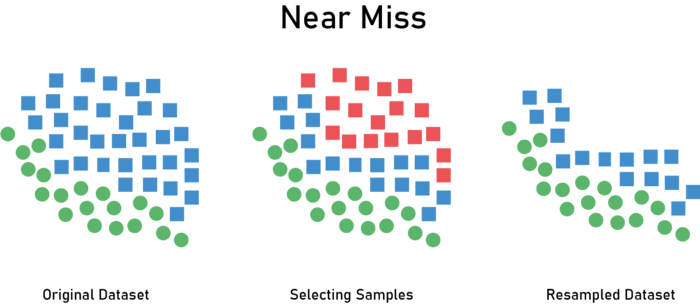

##### 1.2.2.1 NearMiss-1

NearMiss-1 choisit les instances de la classe majoritaire où leurs distances moyennes par rapport aux trois instances les plus proches de la classe minoritaire sont les plus faibles.

In [32]:
# On instancie l'objet 
near_1 = NearMiss(sampling_strategy='not minority', version = 1) # J'utilise not minority puisque c'est plus applicable 
                                                                        #si jamais on travaille avec nb features > 2

# On adapte l'objet aux données
x_near_1, y_near_1 = near_1.fit_sample(X_des_2, y_des_2)

print('Distribution après NearMiss-1(Entropie): {}'.format(Equilibre(y_near_1)))

Distribution après NearMiss-1(Entropie): 1.0


On teste l'effet de la méthode sur la performance du classificateur

In [33]:
etapes = [('nearmiss_1', NearMiss(sampling_strategy='not minority', version = 1)), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_results_near_1 = cross_validate(pipeline,X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_near_1['test_accuracy']),
                                                               np.mean(cv_results_near_1['train_accuracy']),
                                                               np.mean(cv_results_near_1['test_roc_auc'])))

Test Accuracy: 0.9715 ; Training Accuracy : 0.9807 ; Roc_Auc: 0.9340 


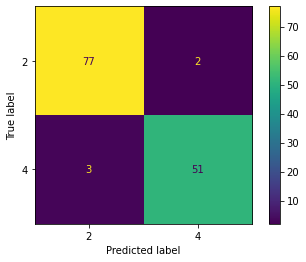

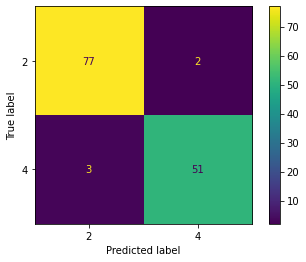

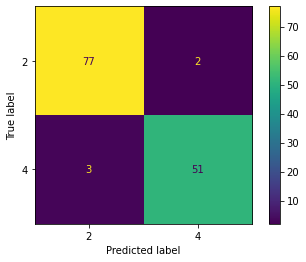

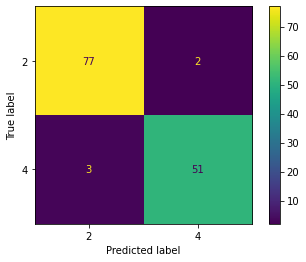

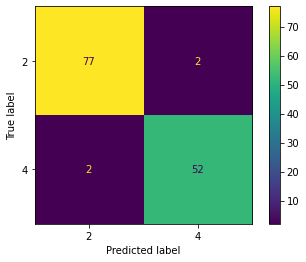

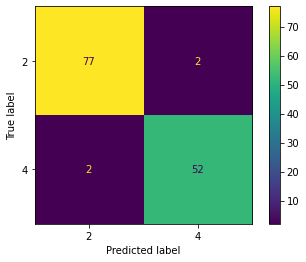

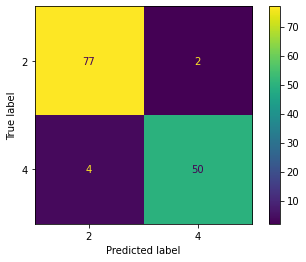

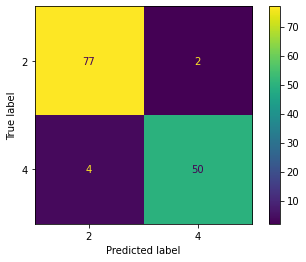

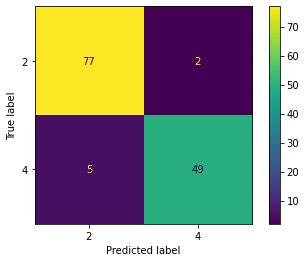

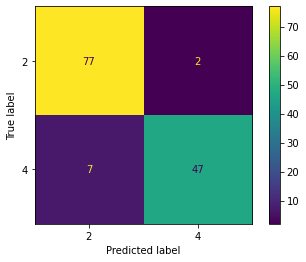

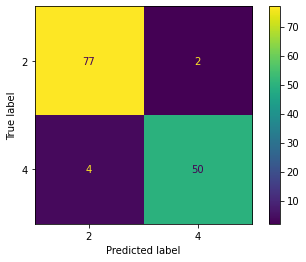

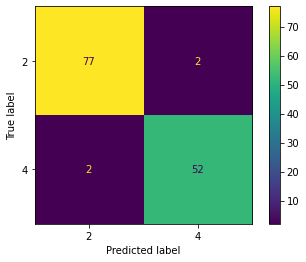

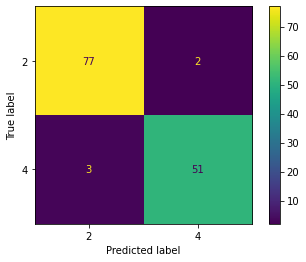

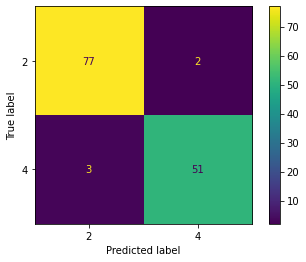

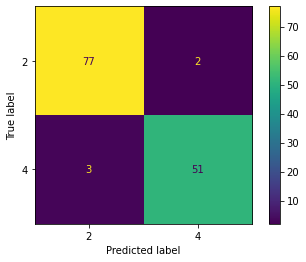

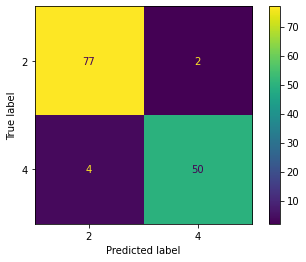

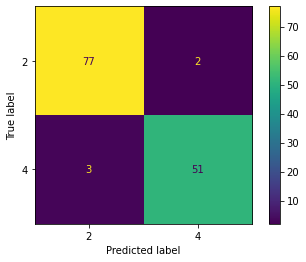

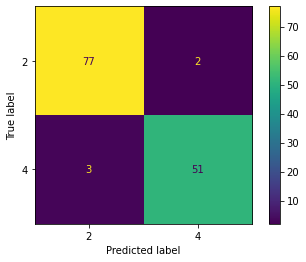

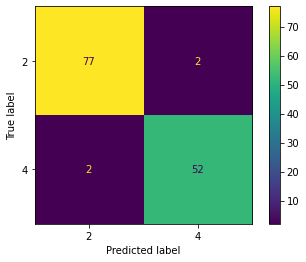

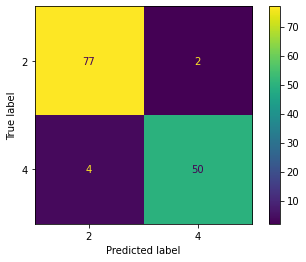

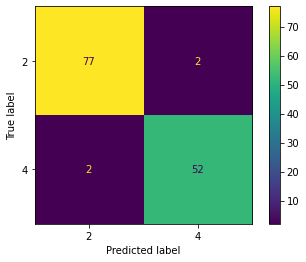

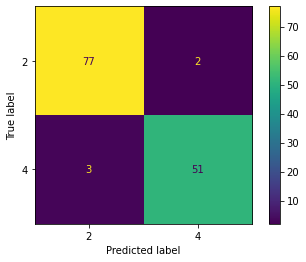

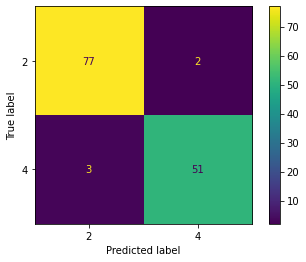

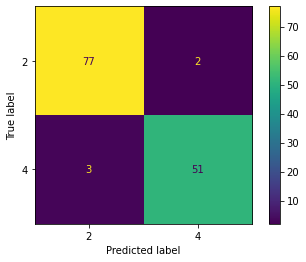

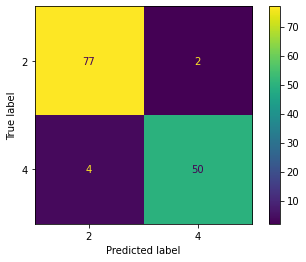

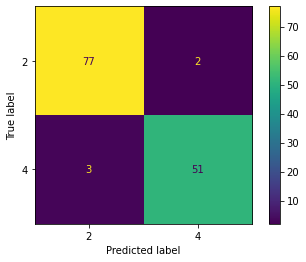

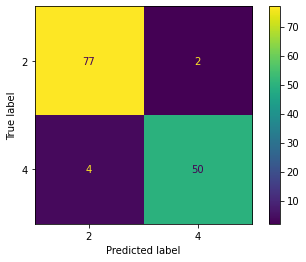

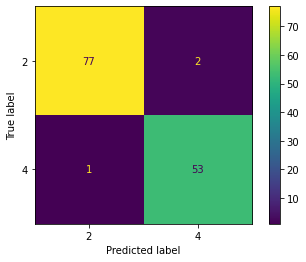

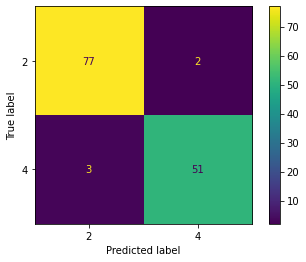

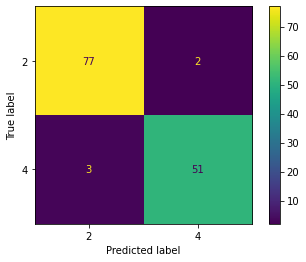

In [34]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_results_near_1['estimator']:
    plot_confusion_matrix(estimator, X_test, y_test)

##### 1.2.2.2 NearMiss-2

NearMiss-2 utilise les trois échantillons les plus éloignés de la classe minoritaire.

In [35]:
# On instancie l'objet 
near_2 = NearMiss(sampling_strategy='not minority', version = 2) # J'utilise not minority puisque c'est plus applicable 
                                                                        #si jamais on travaille avec nb features > 2

# On adapte l'objet aux données
x_near_2, y_near_2 = near_2.fit_sample(X_des_2, y_des_2)

print('Distribution après NearMiss-2(Entropie): {}'.format(Equilibre(y_near_2)))

Distribution après NearMiss-2(Entropie): 1.0


On teste l'effet de la méthode sur la performance du classificateur

In [36]:
etapes = [('nearmiss_2', NearMiss(sampling_strategy='not minority', version = 2)), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_results_near_2 = cross_validate(pipeline,X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_near_2['test_accuracy']),
                                                               np.mean(cv_results_near_2['train_accuracy']),
                                                               np.mean(cv_results_near_2['test_roc_auc'])))

Test Accuracy: 0.9715 ; Training Accuracy : 0.9807 ; Roc_Auc: 0.9340 


Même que NearMiss-1

##### 1.2.2.3 NearMiss-3

NearMiss-3 choisit un nombre donné des échantillons les plus proches de la classe majoritaire pour chaque échantillon de la classe minoritaire.(n_neighbors_ver3->Default=3)

In [37]:
# On instancie l'objet 
near_3 = NearMiss(sampling_strategy='not minority', version = 3) # J'utilise not minority puisque c'est plus applicable 
                                                                        #si jamais on travaille avec nb features > 2

# On adapte l'objet aux données
x_near_3, y_near_3 = near_3.fit_sample(X_des_2, y_des_2)

print('Distribution après NearMiss-3(Entropie): {}'.format(Equilibre(y_near_3)))

Distribution après NearMiss-3(Entropie): 0.849054424254048


On teste l'effet de la méthode sur la performance du classificateur

In [38]:
etapes = [('nearmiss_3', NearMiss(sampling_strategy='not minority', version = 3)), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_results_near_3 = cross_validate(pipeline,X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_near_3['test_accuracy']),
                                                               np.mean(cv_results_near_3['train_accuracy']),
                                                               np.mean(cv_results_near_3['test_roc_auc'])))

Test Accuracy: 0.9694 ; Training Accuracy : 0.9794 ; Roc_Auc: 0.9299 


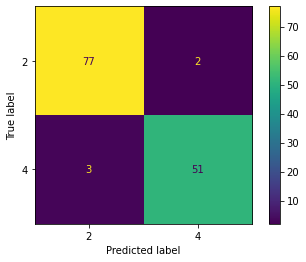

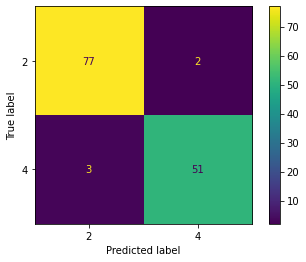

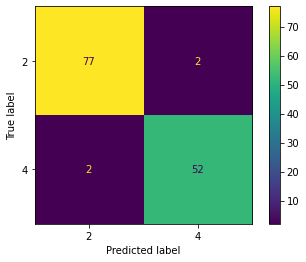

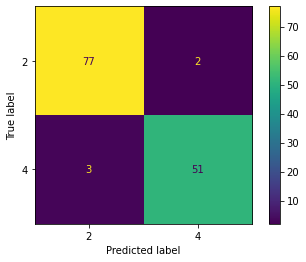

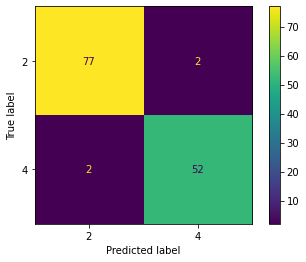

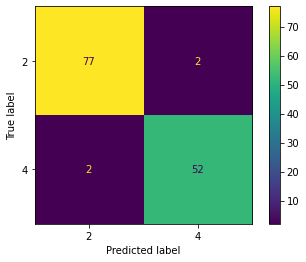

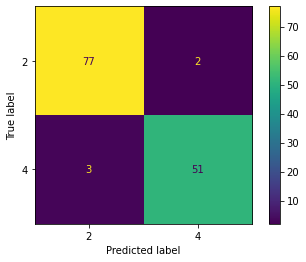

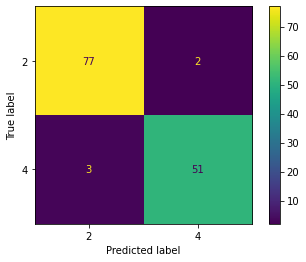

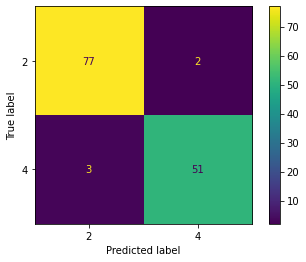

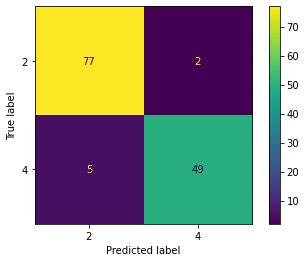

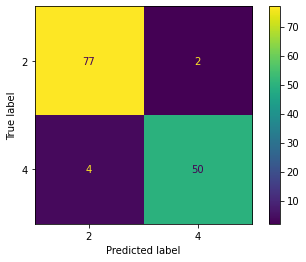

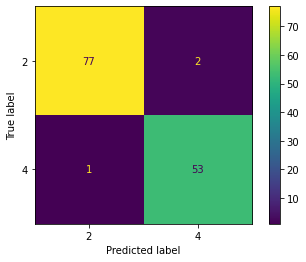

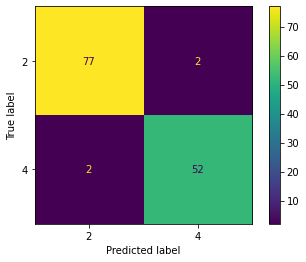

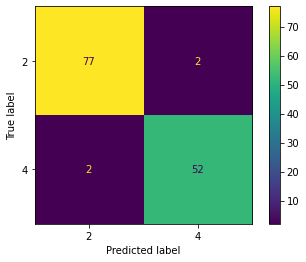

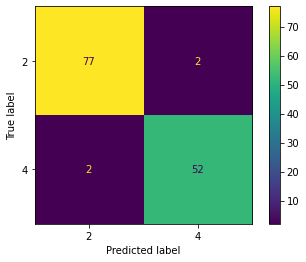

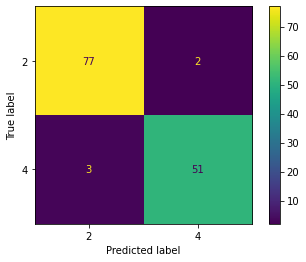

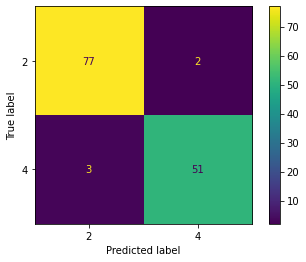

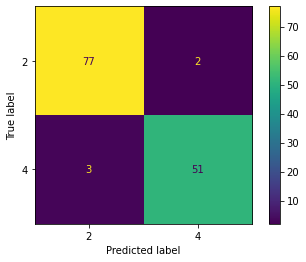

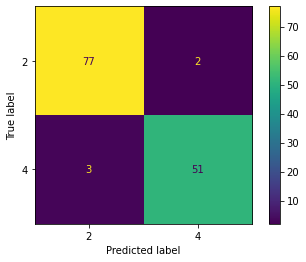

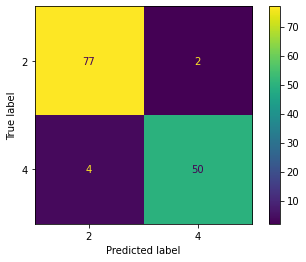

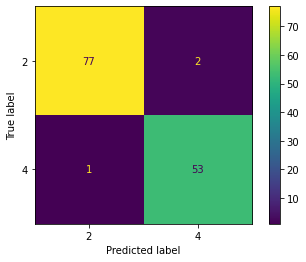

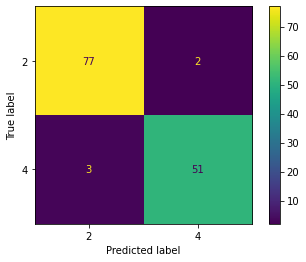

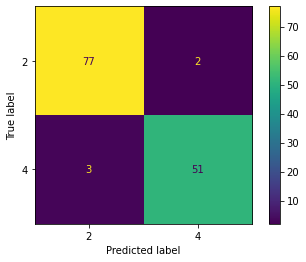

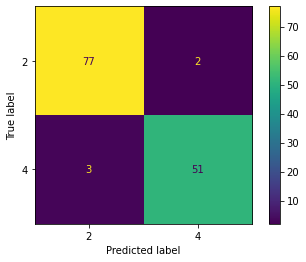

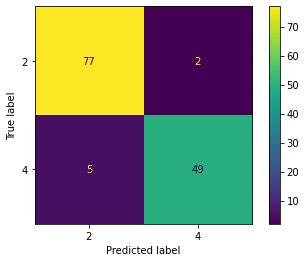

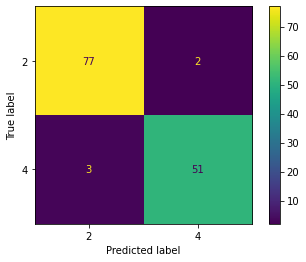

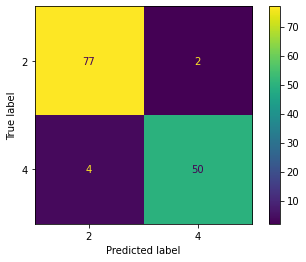

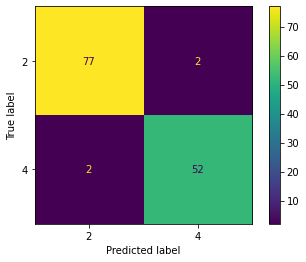

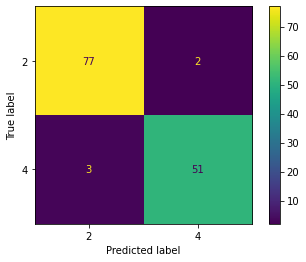

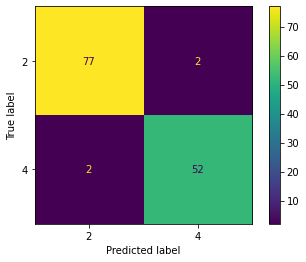

In [39]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_results_near_3['estimator']:
    plot_confusion_matrix(estimator, X_test, y_test)

#### 1.2.3. Tomek Links

Les liens de Tomek(Tomek links) sont des paires d'instances très proches qui appartiennent à des classes différentes. Ce sont des échantillons proches de la frontière entre les classes. En supprimant les exemples de la classe majoritaire de chaque paire, nous augmentons l'espace entre les deux classes et nous nous rapprochons de l'équilibre de l'ensemble des données en supprimant ces points.<br>
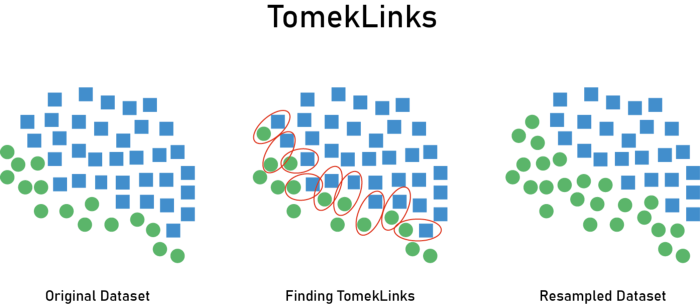

In [40]:
# On instancie l'objet 
tomek = TomekLinks(sampling_strategy='majority') 

# On adapte l'objet aux données
x_tomek, y_tomek = tomek.fit_sample(X_des_2, y_des_2)

print('Distribution après TomekLinks(Entropie): {}'.format(Equilibre(y_tomek)))

Distribution après TomekLinks(Entropie): 0.48477762107066763


###### On voit que l'effet de cet équilibrage est quasi-négligeable. Je pense que ce dataset a un très petit nombre d'instances sur la frontière Minorité/Majorité.

#### 1.2.4. Cluster Centroids

L'idée ici est essentiellement de retirer l'instance sans importance de la classe majoritaire. Pour décider si une instance est importante ou non, nous utilisons le concept de regroupement sur la géométrie de l'espace des caractéristiques.<br>
Le clustering est une approche d'apprentissage non supervisée, dans laquelle les clusters créent des points de données encerclant des appartenances.<br>
Nous ne l'utiliserons que pour trouver les cluster centroïdes  obtenus en calculant la moyenne des vecteurs de caractéristiques pour toutes les caractéristiques sur les points de données.<br>
Après avoir trouvé le centroïde de la classe majoritaire, nous décidons ce qui suit :
>L'instance appartenant au cluster (classe majoritaire), qui est la plus éloignée du cluster centroïde dans l'espace des caractéristiques, est considérée comme l'instance la moins importante.<br>
>L'instance appartenant à la classe majoritaire, qui est la plus proche du cluster centroïde  dans l'espace de caractéristiques, est considérée comme l'instance la plus importante.<br>
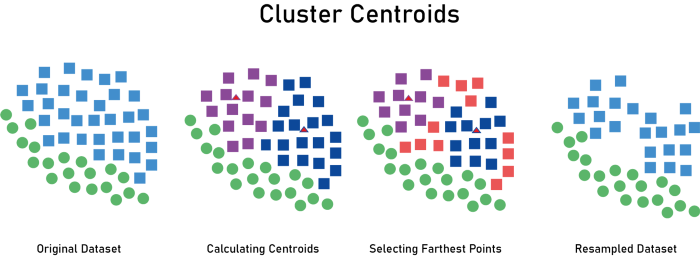

In [41]:
# On instancie l'objet 
cc_km = ClusterCentroids(sampling_strategy="auto")

# On adapte l'objet aux données
x_cc_km, y_cc_km = cc_km.fit_sample(X_des_2, y_des_2)

print('Distribution après ClusterCentroids(Entropie): {}'.format(Equilibre(y_cc_km)))

Distribution après ClusterCentroids(Entropie): 1.0


In [42]:
etapes = [('cc_km', ClusterCentroids(sampling_strategy="auto")), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_cc_km = cross_validate(pipeline,X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_cc_km['test_accuracy']),
                                                               np.mean(cv_cc_km['train_accuracy']),
                                                               np.mean(cv_cc_km['test_roc_auc'])))

Test Accuracy: 0.9715 ; Training Accuracy : 0.9799 ; Roc_Auc: 0.9340 


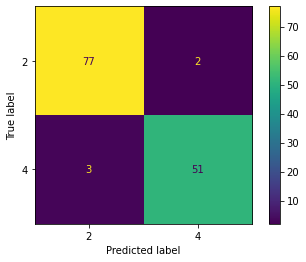

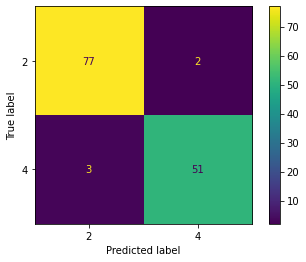

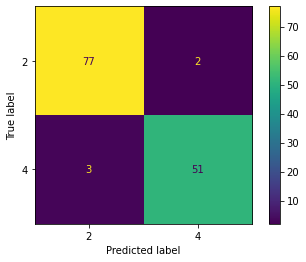

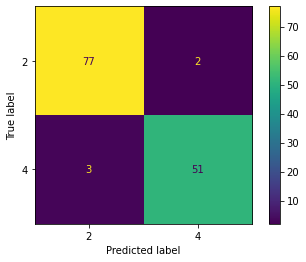

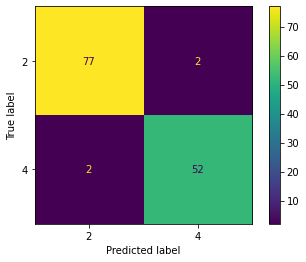

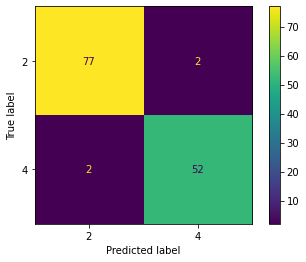

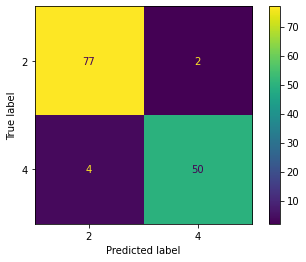

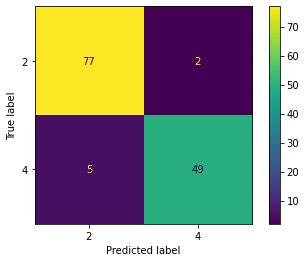

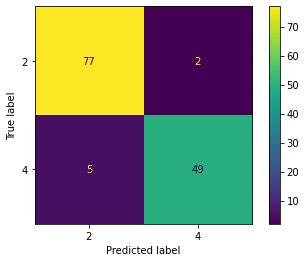

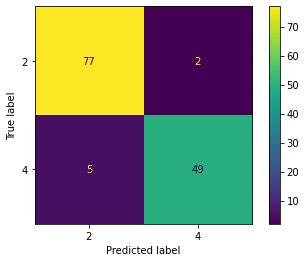

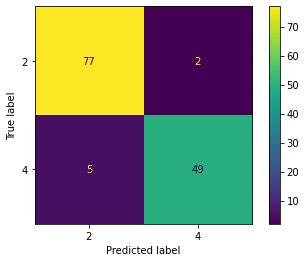

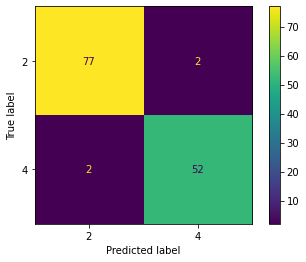

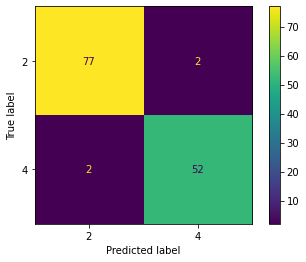

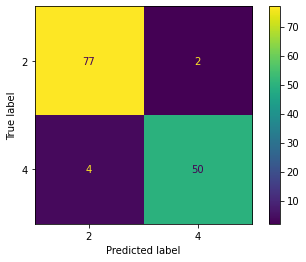

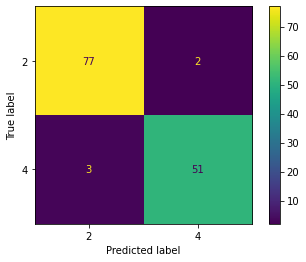

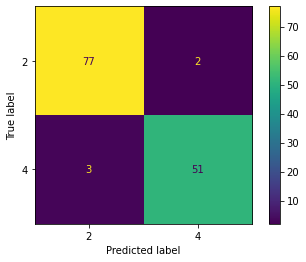

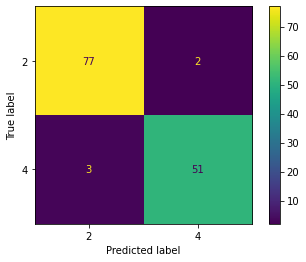

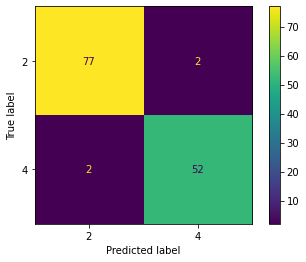

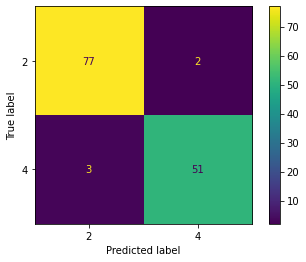

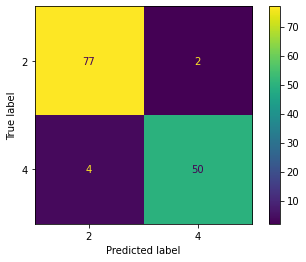

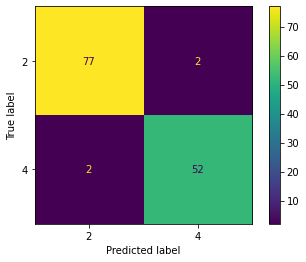

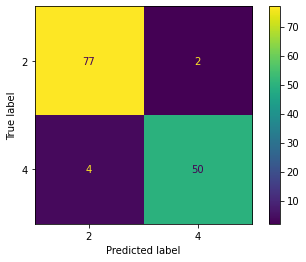

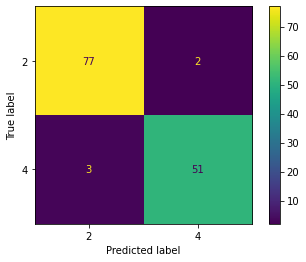

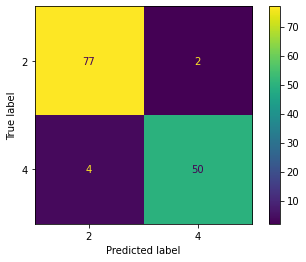

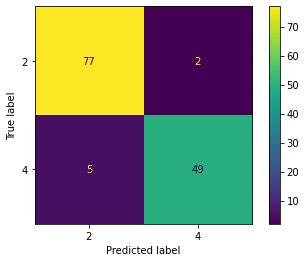

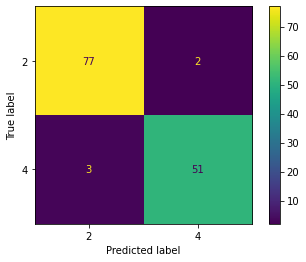

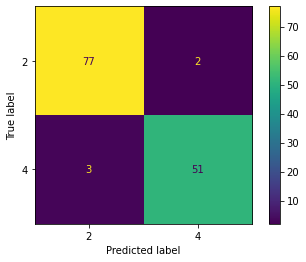

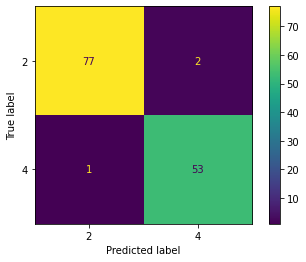

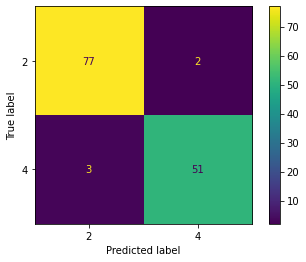

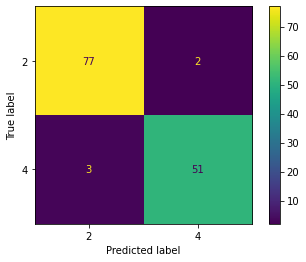

In [43]:
import warnings; warnings.simplefilter('ignore')

for estimator in cv_cc_km['estimator']:
    plot_confusion_matrix(estimator, X_test, y_test)

#### 1.2.5. Edited Nearest Neighbor Rule

L'Edited Nearest Neighbor Rule (ou ENN) a été proposée en 1972 pour supprimer des instances de la classe majoritaire (sous-échantillonnage).<br>
Cette technique permet de supprimer de la classe majoritaire toute instance dont le label de classe est différent de celui d'au moins deux de ses trois voisins les plus proches. En termes généraux, elle est proche ou proche de la limite des différentes classes.<br>
Il s'agit ici d'accroître la précision de la classification des instances minoritaires plutôt que des instances majoritaires.
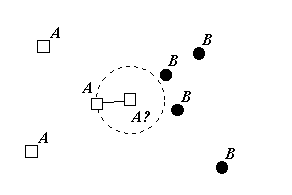

In [44]:
# On instancie l'objet 
enn = EditedNearestNeighbours(sampling_strategy="majority")

# On adapte l'objet aux données
x_enn, y_enn = enn.fit_sample(X_des_2, y_des_2)

print('Distribution après ENN(Entropie): {}'.format(Equilibre(y_enn)))

Distribution après ENN(Entropie): 0.49382740769875216


###### Le résultat est légèrement meilleur que TomekLinks mais reste faible, ce qui est logique puisqu'on garde le même principe de limites de classes cependant l'application diffère.

 #### 1.2.6 Neighborhood Cleaning Rule

La Neighborhood Cleaning Rule ( ou NCR) traite séparément les échantillons majoritaires et minoritaires lors de l'échantillonnage des ensembles de données.<br>
La NCR commence par calculer les trois voisins les plus proches pour toutes les instances de l'ensemble de formation. On procède ensuite de la manière suivante :<br>
>Si l'instance appartient à la classe majoritaire et que la classification donnée par ses trois voisins les plus proches est l'inverse de la classe de l'instance choisie - alors l'instance choisie est supprimée.<br>
>Si l'instance appartient à la classe minoritaire et qu'elle est mal classée par ses trois plus proches voisins, alors les plus proches voisins appartenant à la classe majoritaire sont supprimés.

In [45]:
ncr = NeighbourhoodCleaningRule(sampling_strategy="majority")

x_ncr, y_ncr = ncr.fit_sample(X_des_2, y_des_2)

print('Distribution après NCR(Entropie): {}'.format(Equilibre(y_ncr)))

Distribution après NCR(Entropie): 0.4875229918975016


 #### 1.2.7 Synthèse Undersampling

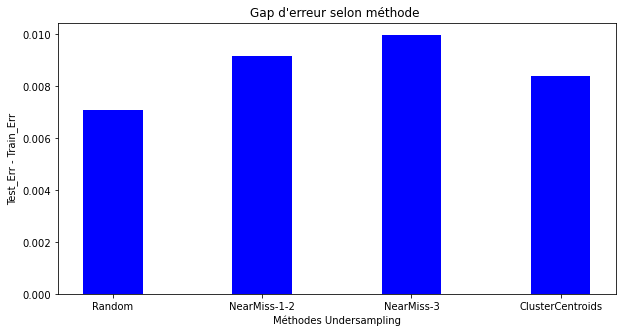

In [46]:
# On définit un dictionnaire avec pour éléments les différences d'erreurs:
#On simplifie les 1
err_diffs_under={'Random': np.mean(cv_results_rand_under_samp['train_accuracy'])-np.mean(cv_results_rand_under_samp['test_accuracy']),
           'NearMiss-1-2': np.mean(cv_results_near_1['train_accuracy'])-np.mean(cv_results_near_1['test_accuracy']),
           'NearMiss-3': np.mean(cv_results_near_3['train_accuracy'])-np.mean(cv_results_near_3['test_accuracy']),
           'ClusterCentroids': np.mean(cv_cc_km['train_accuracy'])-np.mean(cv_cc_km['test_accuracy']),
           }



fig = plt.figure(figsize = (10, 5));

plt.bar(err_diffs_under.keys(), err_diffs_under.values(), color ='blue',width = 0.4)


plt.xlabel("Méthodes Undersampling") 
plt.ylabel("Test_Err - Train_Err") 
plt.title("Gap d'erreur selon méthode ") 
plt.show() 

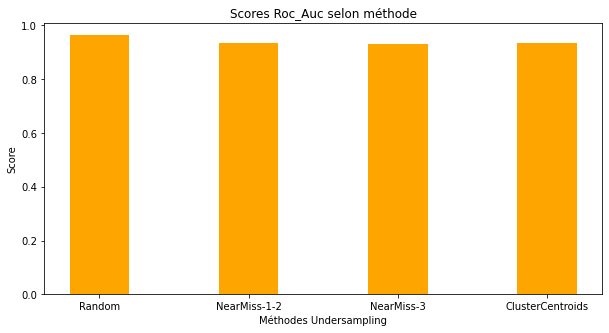

In [47]:
roc_auc={'Random': np.mean(cv_results_rand_under_samp['test_roc_auc']),
           'NearMiss-1-2': np.mean(cv_results_near_1['test_roc_auc']),
           'NearMiss-3': np.mean(cv_results_near_3['test_roc_auc']),
           'ClusterCentroids': np.mean(cv_cc_km['test_roc_auc']),
           }

fig = plt.figure(figsize = (10, 5));

plt.bar(roc_auc.keys(), roc_auc.values(), color ='orange',width = 0.4)


plt.xlabel("Méthodes Undersampling") 
plt.ylabel("Score") 
plt.title("Scores Roc_Auc selon méthode") 
plt.show()


On voit que les scores Roc_Auc sont à peu près les mêmes. Le choix se réduit donc aux erreurs(Overfitting). Je dirais que dans ce cas il est mieux de choisir l'algo ClusterCentroids

### 1.3. Correction - Combination de Méthodes

On peut combiner des méthodes d'oversampling et undersampling afin d'obtenir de meilleurs résultats d'échantillonnage. 

#### 1.3.1. SMOTE & Tomek Links

In [48]:
# On instancie l'objet 
smotemek = SMOTETomek(sampling_strategy='auto')

# On adapte l'objet aux données
x_smotemek, y_smotemek = smotemek.fit_sample(X_des_2, y_des_2)

print('Distribution après SMOTEMEK(Entropie): {}'.format(Equilibre(y_smotemek)))

Distribution après SMOTEMEK(Entropie): 1.0


In [49]:
etapes = [('smotemek', SMOTETomek(sampling_strategy='auto')), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_smotemek = cross_validate(pipeline,X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_smotemek['test_accuracy']),
                                                               np.mean(cv_smotemek['train_accuracy']),
                                                               np.mean(cv_smotemek['test_roc_auc'])))

Test Accuracy: 0.9708 ; Training Accuracy : 0.9796 ; Roc_Auc: 0.9336 


#### 1.3.2. SMOTE & Edited Nearest Neighbor

In [50]:
# On instancie l'objet 
smoenn = SMOTEENN(sampling_strategy='minority')

# On adapte l'objet aux données
x_smoenn, y_smoenn = smoenn.fit_sample(X_des_2, y_des_2)

print('Distribution après SMOENN(Entropie): {}'.format(Equilibre(y_smoenn)))

Distribution après SMOENN(Entropie): 0.9995890795699002


In [51]:
etapes = [('smoenn',  SMOTEENN(sampling_strategy='minority')), ('modele', LogisticRegression())]
pipeline = Pipeline(steps=etapes)
cv_smoenn = cross_validate(pipeline,X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_smoenn['test_accuracy']),
                                                               np.mean(cv_smoenn['train_accuracy']),
                                                               np.mean(cv_smoenn['test_roc_auc'])))

Test Accuracy: 0.9590 ; Training Accuracy : 0.9625 ; Roc_Auc: 0.9565 


#### 1.3.3. Comparaison & Synthèse

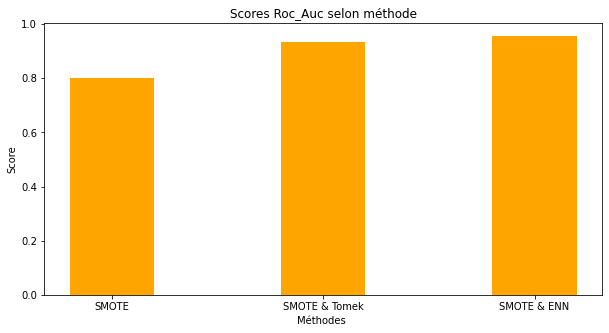

In [52]:
# Comparaison des scores roc_auc
roc_auc_comb={'SMOTE': np.mean(cv_results_smote['test_roc_auc']),
           'SMOTE & Tomek': np.mean(cv_smotemek['test_roc_auc']),
           'SMOTE & ENN': np.mean(cv_smoenn['test_roc_auc'])
           }

fig = plt.figure(figsize = (10, 5));

plt.bar(roc_auc_comb.keys(), roc_auc_comb.values(), color ='orange',width = 0.4)


plt.xlabel("Méthodes ") 
plt.ylabel("Score") 
plt.title("Scores Roc_Auc selon méthode") 
plt.show()

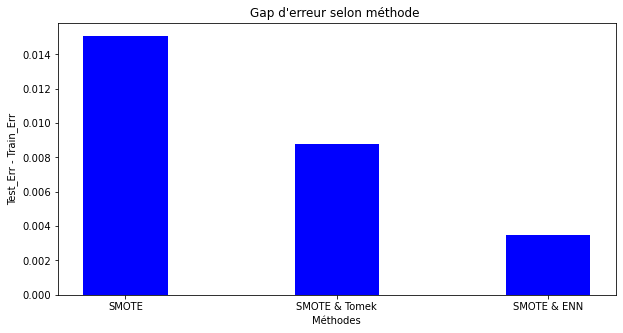

In [53]:
err_diffs_comb={'SMOTE': np.mean(cv_results_smote['train_accuracy'])-np.mean(cv_results_smote['test_accuracy']),
           'SMOTE & Tomek': np.mean(cv_smotemek['train_accuracy'])-np.mean(cv_smotemek['test_accuracy']),
           'SMOTE & ENN': np.mean(cv_smoenn['train_accuracy'])-np.mean(cv_smoenn['test_accuracy']),
           }



fig = plt.figure(figsize = (10, 5));

plt.bar(err_diffs_comb.keys(), err_diffs_comb.values(), color ='blue',width = 0.4)


plt.xlabel("Méthodes") 
plt.ylabel("Test_Err - Train_Err") 
plt.title("Gap d'erreur selon méthode ") 
plt.show() 

###### =>On déduit que SMOTE & ENN > SMOTE & Tomek > SMOTE

### 1.4. Correction - Utilisation d'algorithmes pénalisés

On peut en outre utiliser des algorithmes dont le fonctionnement prend en compte le déséquilibre du set de données avec lequel on travaille.

In [54]:
#BASELINE de la performance

#Déséquilibre 1
modele = LogisticRegression()
cv_results = cross_validate(modele, X_des, y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                            cv=cv, n_jobs=-1,return_estimator=True,return_train_score=True)
# On récupère les scores au pluriel puisque nous validons sur plusieurs vagues et on moyenne sur ces différents scores
print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results['test_accuracy']),
                                                               np.mean(cv_results['train_accuracy']),
                                                               np.mean(cv_results['test_roc_auc'])))

Testing Accuracy: 0.9643 ; Training Accuracy: 0.9837 ; Roc_Auc: 0.7596 


In [55]:
#Déséquilibre 2

modele = LogisticRegression()
cv_results_2 = cross_validate(modele, X_des_2, y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                            cv=cv, n_jobs=-1,return_estimator=True,return_train_score=True)
# On récupère les scores au pluriel puisque nous validons sur plusieurs vagues et on moyenne sur ces différents scores
print('Testing Accuracy: %.4f ; Training Accuracy: %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_results_2['test_accuracy']),
                                                               np.mean(cv_results_2['train_accuracy']),
                                                               np.mean(cv_results_2['test_roc_auc'])))

Testing Accuracy: 0.9701 ; Training Accuracy: 0.9812 ; Roc_Auc: 0.9215 


#### 1.4.1 Penalisation Ridge ( LogReg)

On l'utilisera comme baseline de performance

In [56]:
# Déséquilibre 1
cv_l2_1 = cross_validate(SGDClassifier(penalty='l2'),X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_l2_1['test_accuracy']),
                                                               np.mean(cv_l2_1['train_accuracy']),
                                                               np.mean(cv_l2_1['test_roc_auc'])))

Test Accuracy: 0.9381 ; Training Accuracy : 0.9484 ; Roc_Auc: 0.7933 


In [57]:
# Déséquilibre 2
cv_l2_2 = cross_validate(SGDClassifier(penalty='l2'),X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_l2_2['test_accuracy']),
                                                               np.mean(cv_l2_2['train_accuracy']),
                                                               np.mean(cv_l2_2['test_roc_auc'])))

Test Accuracy: 0.9569 ; Training Accuracy : 0.9629 ; Roc_Auc: 0.9053 


#### 1.4.2 Penalisation ElasticNet(l1 & l2) (LogReg)

In [58]:
# Déséquilibre 1
cv_elas_1 = cross_validate(SGDClassifier(penalty='elasticnet'),X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_elas_1['test_accuracy']),
                                                               np.mean(cv_elas_1['train_accuracy']),
                                                               np.mean(cv_elas_1['test_roc_auc'])))

Test Accuracy: 0.9397 ; Training Accuracy : 0.9512 ; Roc_Auc: 0.8258 


In [59]:
# Déséquilibre 2
cv_elas_2 = cross_validate(SGDClassifier(penalty='elasticnet'),X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_elas_2['test_accuracy']),
                                                               np.mean(cv_elas_2['train_accuracy']),
                                                               np.mean(cv_elas_2['test_roc_auc'])))

Test Accuracy: 0.9632 ; Training Accuracy : 0.9613 ; Roc_Auc: 0.9205 


#### 1.4.3 Standard Bagging (LogReg)

In [60]:
# Déséquilibre 1
cv_bag_1 = cross_validate(BaggingClassifier(LogisticRegression()),X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_bag_1['test_accuracy']),
                                                               np.mean(cv_bag_1['train_accuracy']),
                                                               np.mean(cv_bag_1['test_roc_auc'])))

Test Accuracy: 0.9683 ; Training Accuracy : 0.9839 ; Roc_Auc: 0.7933 


In [61]:
# Déséquilibre 2
cv_bag_2 = cross_validate(BaggingClassifier(LogisticRegression()),X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_bag_2['test_accuracy']),
                                                               np.mean(cv_bag_2['train_accuracy']),
                                                               np.mean(cv_bag_2['test_roc_auc'])))

Test Accuracy: 0.9722 ; Training Accuracy : 0.9812 ; Roc_Auc: 0.9344 


Je n'ai pas traité le Bagging avec Random Undersampling (BalancedBaggingClassifier()) car j'ai déjà traité le Random Undersampling séparément en amont

#### 1.4.4 Boosting - AdaBoost (LogReg)

In [62]:
# Déséquilibre 1
cv_ada_1 = cross_validate(AdaBoostClassifier(LogisticRegression()),X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_ada_1['test_accuracy']),
                                                               np.mean(cv_ada_1['train_accuracy']),
                                                               np.mean(cv_ada_1['test_roc_auc'])))

Test Accuracy: 0.9706 ; Training Accuracy : 0.9773 ; Roc_Auc: 0.8183 


In [63]:
# Déséquilibre 2
cv_ada_2 = cross_validate(AdaBoostClassifier(LogisticRegression()),X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_ada_2['test_accuracy']),
                                                               np.mean(cv_ada_2['train_accuracy']),
                                                               np.mean(cv_ada_2['test_roc_auc'])))

Test Accuracy: 0.9674 ; Training Accuracy : 0.9779 ; Roc_Auc: 0.8993 


#### 1.4.5 EasyEnsemble

EasyEnsemble est une implémentation de ce qui suit Bagging(Adaboost)

In [64]:
# Déséquilibre 1
cv_easy_1 = cross_validate(EasyEnsembleClassifier(base_estimator=LogisticRegression()),X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_easy_1['test_accuracy']),
                                                               np.mean(cv_easy_1['train_accuracy']),
                                                               np.mean(cv_easy_1['test_roc_auc'])))

Test Accuracy: 0.9508 ; Training Accuracy : 0.9551 ; Roc_Auc: 0.9504 


In [65]:
# Déséquilibre 2
cv_easy_2 = cross_validate(EasyEnsembleClassifier(base_estimator=LogisticRegression()),X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_easy_2['test_accuracy']),
                                                               np.mean(cv_easy_2['train_accuracy']),
                                                               np.mean(cv_easy_2['test_roc_auc'])))

Test Accuracy: 0.9632 ; Training Accuracy : 0.9688 ; Roc_Auc: 0.9588 


#### 1.4.5 Weighted Extreme Gradient Boosting - Weighted XGBoost

In [116]:
#Déséquilibre 1

#scale_pos_weight = total_negative_examples / total_positive_examples

# On essaie d'estimer le tuning parameter afin d'avoir une idée du centre de
                            #la fenêtre du grid et éviter un computing intensive gridsearch
# On compte les instances de classes
counter = Counter(y_des)
# on estime scale_pos_weight value
estim = counter[2] / counter[4]
print('Estimation: %.3f' % estim)
# On définit la grille
weights = [1, 10, 20, 50, 75]
param_grid = dict(scale_pos_weight=weights)

xgb_1 = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc',refit=True)

grid_roc_result = xgb_1.fit(X_des, y_des)


print("Roc_Auc(Best): %f using %s" % (np.mean(grid_roc_result.cv_results_['mean_test_score']), grid_roc_result.best_params_))
                    

Estimation: 20.000
Roc_Auc(Best): 0.957542 using {'scale_pos_weight': 10}


In [118]:
#Déséquilibre 2

#scale_pos_weight = total_negative_examples / total_positive_examples

# On essaie d'estimer le tuning parameter afin d'avoir une idée du centre de
                            #la fenêtre du grid et éviter un computing intensive gridsearch
# On compte les instances de classes
counter = Counter(y_des_2)
# on estime scale_pos_weight value
estim_2 = counter[2] / counter[4]
print('Estimation: %.3f' % estim_2)
# On définit la grille
weights = [0.5,1,8, 10, 20]
param_grid = dict(scale_pos_weight=weights)

xgb_2 = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc',refit=True)

grid_roc_result_2 = xgb_2.fit(X_des_2, y_des_2)


print("Roc_Auc(Best): %f using %s" % (np.mean(grid_roc_result_2.cv_results_['mean_test_score']), grid_roc_result_2.best_params_))

Estimation: 8.600
Roc_Auc(Best): 0.985907 using {'scale_pos_weight': 0.5}


#### 1.4.2 Weighted Random Forest 

In [90]:
# Déséquilibre 1
cv_rf_1 = cross_validate(RandomForestClassifier(class_weight='balanced'),X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_rf_1['test_accuracy']),
                                                               np.mean(cv_rf_1['train_accuracy']),
                                                               np.mean(cv_rf_1['test_roc_auc'])))

Test Accuracy: 0.9730 ; Training Accuracy : 1.0000 ; Roc_Auc: 0.7721 


In [68]:
#Déséquilibre 2
cv_rf_2 = cross_validate(RandomForestClassifier(class_weight='balanced'),X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_rf_2['test_accuracy']),
                                                               np.mean(cv_rf_2['train_accuracy']),
                                                               np.mean(cv_rf_2['test_roc_auc'])))

Test Accuracy: 0.9660 ; Training Accuracy : 0.9999 ; Roc_Auc: 0.9015 


#### 1.4.3 SVM -SVC (Rbf=3)(Balanced class weights)

In [69]:
# Déséquilibre 1
# Param class_weight=‘balanced’ important
cv_svc_1 = cross_validate(SVC(class_weight='balanced'),X_des,y_des, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_svc_1['test_accuracy']),
                                                               np.mean(cv_svc_1['train_accuracy']),
                                                               np.mean(cv_svc_1['test_roc_auc'])))

Test Accuracy: 0.9516 ; Training Accuracy : 0.9591 ; Roc_Auc: 0.9350 


In [70]:
# Déséquilibre 2
# Param class_weight=‘balanced’ important
cv_svc_2 = cross_validate(SVC(class_weight='balanced'),X_des_2,y_des_2, scoring={'accuracy':make_scorer(accuracy_score),
                                                       'specificity': make_scorer(recall_score,pos_label=4,average='weighted'),
                                                       'roc_auc':make_scorer(roc_auc_score) }, 
                             cv=cv, n_jobs=-1,return_estimator=True, return_train_score=True)

print('Test Accuracy: %.4f ; Training Accuracy : %.4f ; Roc_Auc: %.4f ' % (np.mean(cv_svc_2['test_accuracy']),
                                                               np.mean(cv_svc_2['train_accuracy']),
                                                               np.mean(cv_svc_2['test_roc_auc'])))

Test Accuracy: 0.9625 ; Training Accuracy : 0.9667 ; Roc_Auc: 0.9614 
